In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
experiment = 'No close LSTM Time Series - cyclic'

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from sklearn import preprocessing

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Cyclic Stocks

### Singapore Airlines

In [5]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14      OBV_7  labels
0  2000-01-21    19.000000  19.215335 -37.499990   388000.0     2.0
1  2000-01-24    18.400000  19.089899 -50.000000 -2311000.0     2.0
2  2000-01-25    18.100000  18.937607 -48.780483 -3542000.0     2.0
3  2000-01-26    17.700001  18.747206 -85.714237 -6261000.0     2.0
4  2000-01-27    17.799999  18.601482 -82.142864 -4565000.0     2.0


In [6]:
df.set_index('Date', inplace=True)

In [7]:
df.drop(['previous_1d'], axis='columns', inplace=True)

In [8]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [9]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
X.shape

(4725, 15, 3)

In [10]:
v = X.reshape(X.shape[0],15, 3)
v[0]

array([[1.        , 1.        , 1.        ],
       [0.92783951, 0.78504654, 0.79689969],
       [0.8402295 , 0.80601767, 0.70426669],
       [0.73069638, 0.17089513, 0.49966137],
       [0.64686477, 0.23230939, 0.62728573],
       [0.59363121, 0.35514026, 0.70140718],
       [0.57513856, 0.56213184, 0.83332079],
       [0.51523893, 0.24368262, 0.71510272],
       [0.45570436, 0.20037465, 0.64782903],
       [0.42302965, 0.33794397, 0.70140718],
       [0.35112982, 0.06280271, 0.54255399],
       [0.29914193, 0.1967527 , 0.57822259],
       [0.20204974, 0.        , 0.41944465],
       [0.1021941 , 0.11630365, 0.18639476],
       [0.        , 0.05751282, 0.        ]])

In [11]:
y = labels
y = np.array(y)
y.shape

(4725,)

In [12]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [13]:
SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "Close"

In [14]:
import time

EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [15]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [16]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [17]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 31ms/step - loss: 0.2860 - accuracy: 0.4706 - mse: 0.4807 - weighted_accuracy: 0.3544 - weighted_mse: 0.5416 - val_loss: 0.3005 - val_accuracy: 0.0529 - val_mse: 0.3478 - val_weighted_accuracy: 0.0529 - val_weighted_mse: 0.3478
Epoch 2/200
30/30 [==============================] - 0s 8ms/step - loss: 0.2124 - accuracy: 0.3402 - mse: 0.7735 - weighted_accuracy: 0.4252 - weighted_mse: 0.7716 - val_loss: 0.2912 - val_accuracy: 0.0455 - val_mse: 0.3758 - val_weighted_accuracy: 0.0455 - val_weighted_mse: 0.3758
Epoch 3/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1936 - accuracy: 0.3228 - mse: 0.9830 - weighted_accuracy: 0.4666 - weighted_mse: 0.9831 - val_loss: 0.2812 - val_accuracy: 0.0455 - val_mse: 0.4102 - val_weighted_accuracy: 0.0455 - val_weighted_mse: 0.4102
Epoch 4/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1857 - accuracy: 0.2847 - mse: 1.1055 - weighted_accuracy: 0.4843 - weighte

Epoch 30/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1448 - accuracy: 0.3857 - mse: 1.5217 - weighted_accuracy: 0.6638 - weighted_mse: 1.4460 - val_loss: 0.1852 - val_accuracy: 0.3968 - val_mse: 1.4631 - val_weighted_accuracy: 0.3968 - val_weighted_mse: 1.4631
Epoch 31/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1441 - accuracy: 0.4190 - mse: 1.5279 - weighted_accuracy: 0.6798 - weighted_mse: 1.4526 - val_loss: 0.1953 - val_accuracy: 0.3175 - val_mse: 1.4951 - val_weighted_accuracy: 0.3175 - val_weighted_mse: 1.4951
Epoch 32/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1422 - accuracy: 0.3770 - mse: 1.5584 - weighted_accuracy: 0.6809 - weighted_mse: 1.4657 - val_loss: 0.1859 - val_accuracy: 0.3958 - val_mse: 1.4774 - val_weighted_accuracy: 0.3958 - val_weighted_mse: 1.4774
Epoch 33/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1417 - accuracy: 0.4632 - mse: 1.5321 - weighted_accuracy: 0.6921 - weig

Epoch 59/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1213 - accuracy: 0.5476 - mse: 1.8213 - weighted_accuracy: 0.7787 - weighted_mse: 1.7720 - val_loss: 0.1805 - val_accuracy: 0.4825 - val_mse: 1.8365 - val_weighted_accuracy: 0.4825 - val_weighted_mse: 1.8365
Epoch 60/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1199 - accuracy: 0.5640 - mse: 1.8207 - weighted_accuracy: 0.7792 - weighted_mse: 1.7816 - val_loss: 0.1899 - val_accuracy: 0.4476 - val_mse: 1.8694 - val_weighted_accuracy: 0.4476 - val_weighted_mse: 1.8694
Epoch 61/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1197 - accuracy: 0.5508 - mse: 1.8601 - weighted_accuracy: 0.7909 - weighted_mse: 1.8150 - val_loss: 0.1791 - val_accuracy: 0.4878 - val_mse: 1.9079 - val_weighted_accuracy: 0.4878 - val_weighted_mse: 1.9079
Epoch 62/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1196 - accuracy: 0.5283 - mse: 1.8766 - weighted_accuracy: 0.7808 - weig

Epoch 88/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1009 - accuracy: 0.6611 - mse: 2.2487 - weighted_accuracy: 0.8517 - weighted_mse: 2.2591 - val_loss: 0.1684 - val_accuracy: 0.5788 - val_mse: 2.2922 - val_weighted_accuracy: 0.5788 - val_weighted_mse: 2.2922
Epoch 89/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0989 - accuracy: 0.6519 - mse: 2.2808 - weighted_accuracy: 0.8539 - weighted_mse: 2.2765 - val_loss: 0.1629 - val_accuracy: 0.6254 - val_mse: 2.3050 - val_weighted_accuracy: 0.6254 - val_weighted_mse: 2.3050
Epoch 90/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0997 - accuracy: 0.6601 - mse: 2.2822 - weighted_accuracy: 0.8458 - weighted_mse: 2.2959 - val_loss: 0.1884 - val_accuracy: 0.5386 - val_mse: 2.3231 - val_weighted_accuracy: 0.5386 - val_weighted_mse: 2.3231
Epoch 91/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0988 - accuracy: 0.6762 - mse: 2.2968 - weighted_accuracy: 0.8462 - weig

Epoch 117/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0860 - accuracy: 0.7402 - mse: 2.8920 - weighted_accuracy: 0.8825 - weighted_mse: 2.9413 - val_loss: 0.1826 - val_accuracy: 0.5937 - val_mse: 2.9986 - val_weighted_accuracy: 0.5937 - val_weighted_mse: 2.9986
Epoch 118/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0807 - accuracy: 0.7167 - mse: 2.8678 - weighted_accuracy: 0.8813 - weighted_mse: 2.8991 - val_loss: 0.1545 - val_accuracy: 0.7058 - val_mse: 3.0120 - val_weighted_accuracy: 0.7058 - val_weighted_mse: 3.0120
Epoch 119/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0823 - accuracy: 0.7354 - mse: 2.8998 - weighted_accuracy: 0.8919 - weighted_mse: 2.9441 - val_loss: 0.1799 - val_accuracy: 0.6063 - val_mse: 2.9967 - val_weighted_accuracy: 0.6063 - val_weighted_mse: 2.9967
Epoch 120/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0816 - accuracy: 0.7304 - mse: 2.9686 - weighted_accuracy: 0.8864 - 

Epoch 146/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0689 - accuracy: 0.7992 - mse: 3.6683 - weighted_accuracy: 0.9172 - weighted_mse: 3.7024 - val_loss: 0.1761 - val_accuracy: 0.6783 - val_mse: 3.9837 - val_weighted_accuracy: 0.6783 - val_weighted_mse: 3.9837
Epoch 147/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0661 - accuracy: 0.7913 - mse: 3.6980 - weighted_accuracy: 0.9198 - weighted_mse: 3.6893 - val_loss: 0.1784 - val_accuracy: 0.6963 - val_mse: 4.1125 - val_weighted_accuracy: 0.6963 - val_weighted_mse: 4.1125
Epoch 148/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0661 - accuracy: 0.7918 - mse: 3.6916 - weighted_accuracy: 0.9182 - weighted_mse: 3.6805 - val_loss: 0.1833 - val_accuracy: 0.6783 - val_mse: 3.8001 - val_weighted_accuracy: 0.6783 - val_weighted_mse: 3.8001
Epoch 149/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0658 - accuracy: 0.7942 - mse: 3.7308 - weighted_accuracy: 0.9172 - 

Epoch 175/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0574 - accuracy: 0.8360 - mse: 4.6997 - weighted_accuracy: 0.9288 - weighted_mse: 4.5864 - val_loss: 0.2197 - val_accuracy: 0.6444 - val_mse: 4.6753 - val_weighted_accuracy: 0.6444 - val_weighted_mse: 4.6753
Epoch 176/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0603 - accuracy: 0.8124 - mse: 4.6446 - weighted_accuracy: 0.9220 - weighted_mse: 4.5574 - val_loss: 0.2244 - val_accuracy: 0.6360 - val_mse: 4.9044 - val_weighted_accuracy: 0.6360 - val_weighted_mse: 4.9044
Epoch 177/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0542 - accuracy: 0.8437 - mse: 4.8406 - weighted_accuracy: 0.9390 - weighted_mse: 4.7448 - val_loss: 0.1927 - val_accuracy: 0.7101 - val_mse: 4.8676 - val_weighted_accuracy: 0.7101 - val_weighted_mse: 4.8676
Epoch 178/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0529 - accuracy: 0.8455 - mse: 4.8268 - weighted_accuracy: 0.9359 - 

In [18]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

Test loss: 0.2152392864227295
Test accuracy: 0.7365079522132874


In [19]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-2.8152163  -3.1629388   1.4976646 ]
 [-3.1731532  -3.2947495   2.3520808 ]
 [-3.6584969  -0.91777474 -0.21896577]
 ...
 [-3.312353   -2.7501      1.3294206 ]
 [-1.8958714  -4.033472    1.1387709 ]
 [-3.7570539  -0.1474935  -0.31892145]]


Counter({2: 770, 0: 73, 1: 102})

In [20]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 859, 0: 43, 1: 43})

In [21]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 945
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 39
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 41
actual holds but predicted buy: 98
actual holds but predicted sell: 71
actual predicted holds: 690
Percentage buys correct: 9.30232558139535%
Percentage sells correct: 4.651162790697675%
Percentage holds correct: 80.32596041909197%
actual buys: 43
actual sells: 43
actual holds: 859


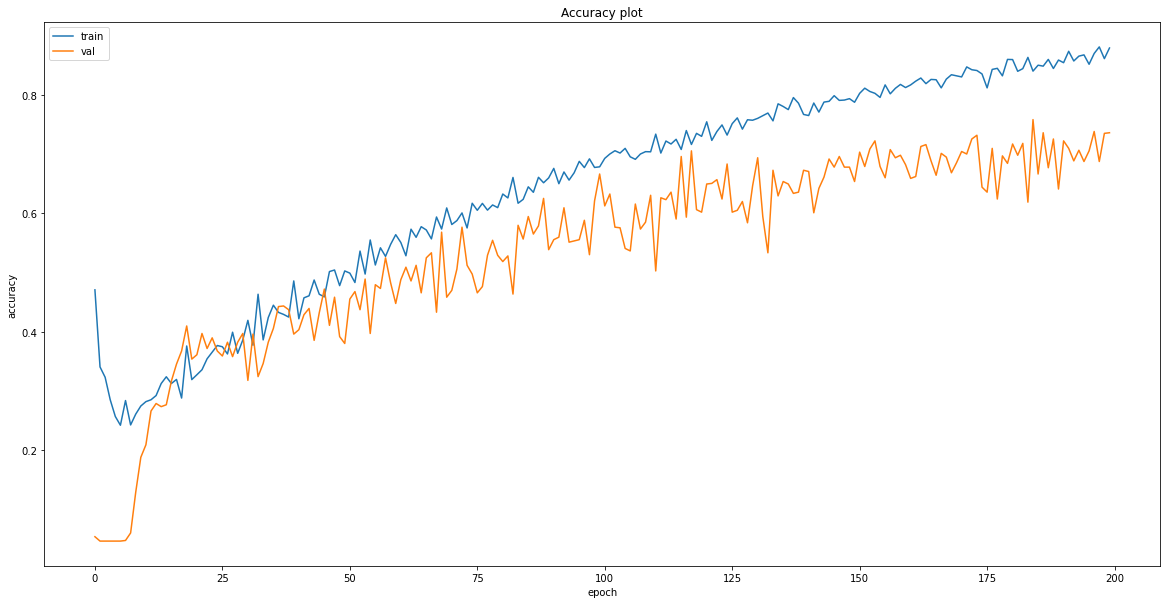

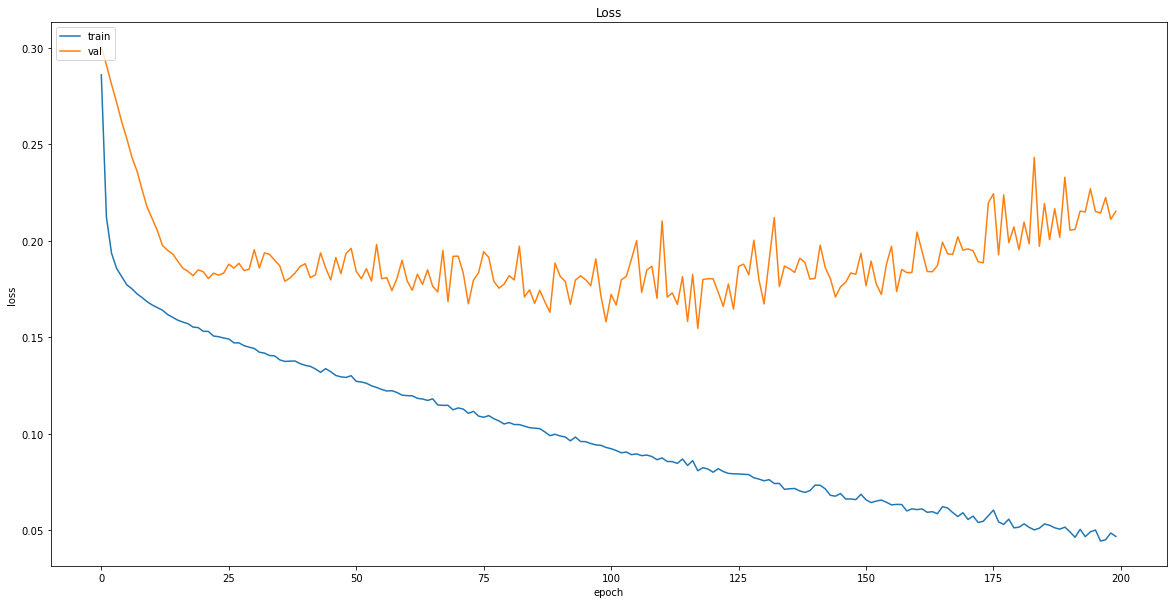

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [23]:
# Save model
model.save("models/{}".format('Singapore_Airlines_time_series_lstm_buy_hold_sell_no_close.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/Singapore_Airlines_time_series_lstm_buy_hold_sell_no_close.model\assets


### Test Performance

### non-recession

In [25]:
column_names = ["Test_accuracy","correct_buys","correct_sells","correct_holds","correct_low_buys","correct_high_sells","correct_mid_holds","Profit gained","buy_n_hold profit"]
log  = pd.DataFrame(columns = column_names)
logger = []

In [26]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2019-01-21         9.59  9.538960 -32.758553  6890900.0     2.0
2019-01-22         9.63  9.552966 -25.862007  7759500.0     2.0
2019-01-23         9.61  9.561740 -29.310362  7108100.0     1.0
2019-01-24         9.50  9.552242 -48.275822  6126400.0     2.0
2019-01-25         9.74  9.581128  -8.888884  8160300.0     2.0


In [27]:
df.drop(['previous_1d'], axis='columns', inplace=True)

In [28]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [29]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(218, 15, 3)

In [30]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [32]:
model = tf.keras.models.load_model("models/Singapore_Airlines_time_series_lstm_buy_hold_sell_no_close.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1528 - accuracy: 0.7339 - mean_squared_error: 5.5457 - weighted_accuracy: 0.7339 - weighted_mean_squared_error: 5.5457
Test loss: 0.15275827050209045
Test accuracy: 0.7339449524879456


In [33]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 164, 1: 32, 0: 22})

In [34]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 200, 0: 9, 1: 9})

In [35]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test.csv")
df.set_index('Date', inplace=True)

In [36]:
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df = df.iloc[13:]
df['predictions'] = predictions
df['actual'] = actual
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-08,9.76,9.644474,-45.454598,5084100.0,2.0,2,2
2019-02-11,9.71,9.662247,-15.151533,6464788.0,2.0,2,2
2019-02-12,9.65,9.669594,-30.303065,5675088.0,2.0,2,2
2019-02-13,9.73,9.666579,-48.484962,4337188.0,2.0,2,2
2019-02-14,9.87,9.676336,-32.000351,5826588.0,2.0,2,2


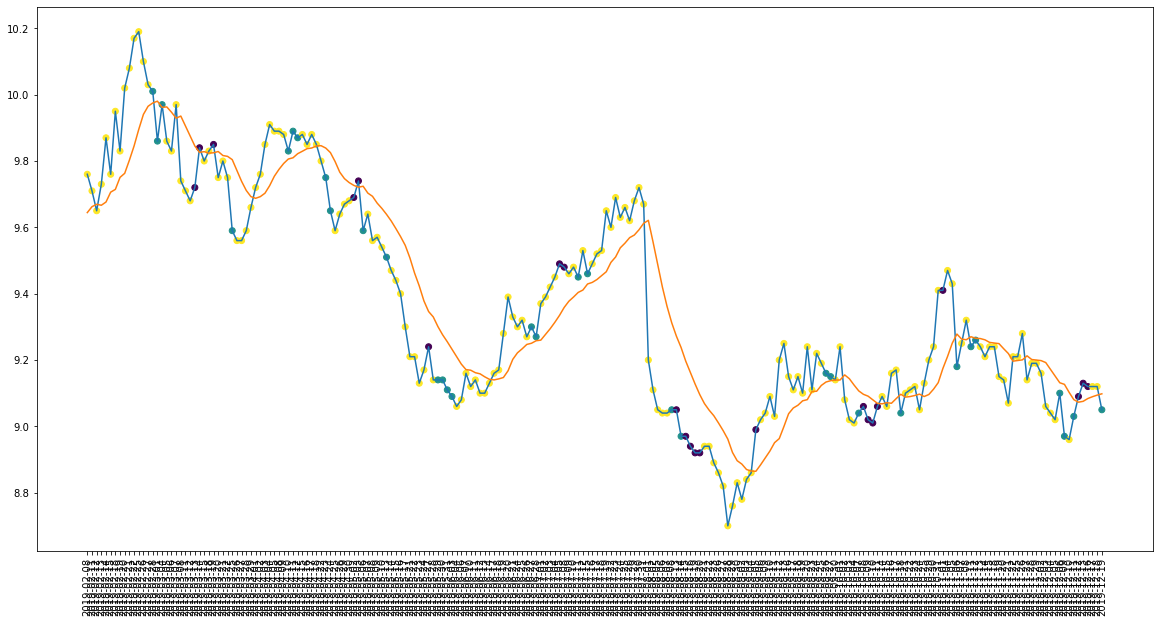

In [37]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [39]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 7
actual holds but predicted buy: 27
actual holds but predicted sell: 20
actual predicted holds: 153
Percentage buys correct: 55.55555555555556%
Percentage sells correct: 22.22222222222222%
Percentage holds correct: 76.5%
actual buys: 9
actual sells: 9
actual holds: 200


In [40]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[9.649999618530273, 9.710000038146973, 9.729999542236328, 9.760000228881836, 9.760000228881836, 9.829999923706056, 9.869999885559082, 9.949999809265137, 10.020000457763672]
[9.829999923706056, 9.949999809265137, 10.010000228881836, 10.020000457763672, 10.029999732971193, 10.079999923706056, 10.100000381469727, 10.170000076293944, 10.1899995803833]
Percentage buys correct: 59.375%
Percentage sells correct: 63.63636363636363%
Percentage holds correct: 81.70731707317073%


In [41]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $10.010000228881836
Shares owned at the moment: 996
Cash capital at the moment: $2.622381406783461


Stop Loss Activated!

Share price: $9.710000038146973
Shares owned at the moment: 0
Cash capital at the moment: $9647.186729296684


Share price: $9.59000015258789
Shares owned at the moment: 1003
Cash capital at the moment: $1.9649583301525126


Stop Loss Activated!

Share price: $9.300000190734863
Shares owned at the moment: 0
Cash capital at the moment: $9304.213424111125


Share price: $9.140000343322754
Shares owned at the moment: 1015
Cash capital at the moment: $1.6010496802300622


Stop Loss Activated!

Share price: $8.890000343322754
Shares owned at the moment: 0
Cash capital at the moment: $9000.137184694526


Share price: $9.15999984741211
Shares owned at the moment: 979
Cash capital at the moment: $7.836324488875107




Capital at the end of test period: $8843.4216482048
profit gained: -11.565783517952005%


In [42]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9222.27618237376
profit gained: -7.777238176262399%


In [43]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.733945,55.55555555555556%,22.22222222222222%,76.5%,59.375%,63.63636363636363%,81.70731707317073%,-11.565783517952005%,-7.777238176262399%


### Recession

In [44]:
logger = []

In [45]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2020-01-22         8.84  8.979182 -96.551645  -851200.0     2.0
2020-01-23         8.93  8.971615 -65.517105  1644900.0     2.0
2020-01-24         8.85  8.952905 -92.307523  -246900.0     2.0
2020-01-28         8.82  8.932458 -75.000000 -1718200.0     2.0
2020-01-29         8.56  8.875157 -86.885115 -5499900.0     2.0


In [46]:
df.drop(['previous_1d'], axis='columns', inplace=True)

In [47]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [48]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(215, 15, 3)

In [49]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [50]:
model = tf.keras.models.load_model("models/Singapore_Airlines_time_series_lstm_buy_hold_sell_no_close.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1848 - accuracy: 0.7302 - mean_squared_error: 5.9791 - weighted_accuracy: 0.7302 - weighted_mean_squared_error: 5.9791
Test loss: 0.18483367562294006
Test accuracy: 0.7302325367927551


In [51]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 169, 0: 9, 1: 37})

In [52]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [53]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test2.csv")
df.set_index('Date', inplace=True)

In [54]:
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df = df.iloc[13:]
df['predictions'] = predictions
df['actual'] = actual
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,8.53,8.641035,-89.830440,-3476200.0,2.0,2,2
2020-02-12,8.64,8.623953,-86.440694,-2356000.0,2.0,0,2
2020-02-13,8.59,8.626421,-61.224363,-575600.0,2.0,0,2
2020-02-14,8.62,8.620818,-64.102508,-2132700.0,2.0,0,2
2020-02-17,8.66,8.620692,-45.161340,-798700.0,2.0,0,2


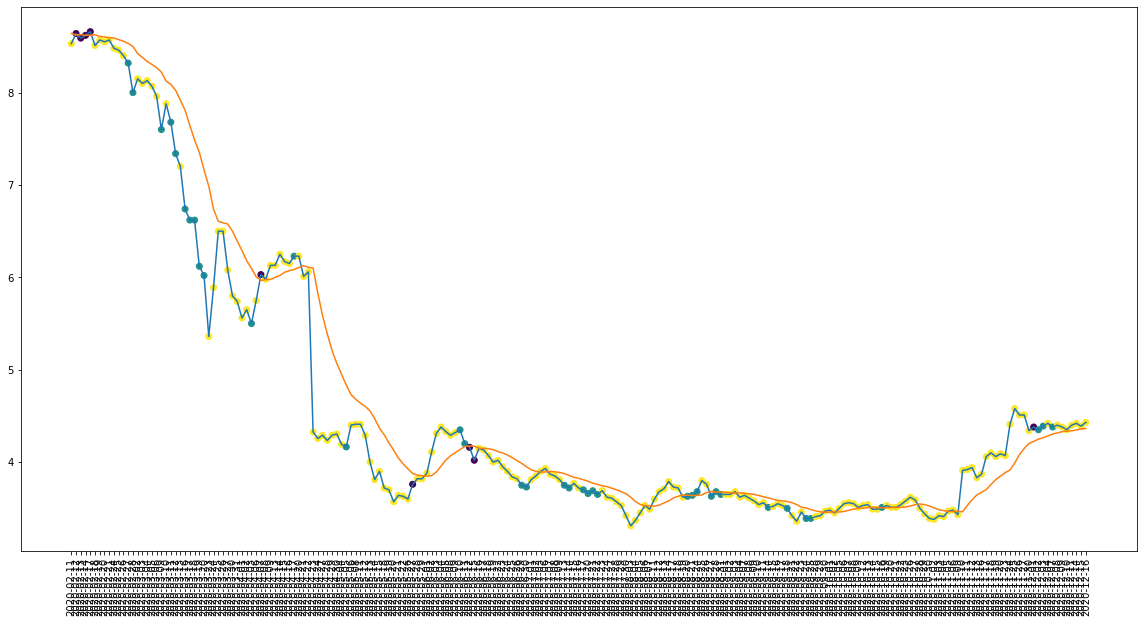

In [55]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [56]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 215
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 0
actual sells but predicted hold: 8
actual holds but predicted buy: 34
actual holds but predicted sell: 9
actual predicted holds: 155
Percentage buys correct: 25.0%
Percentage sells correct: 0.0%
Percentage holds correct: 78.28282828282828%
actual buys: 8
actual sells: 9
actual holds: 198


In [57]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[8.510000228881836, 8.529999732971191, 8.550000190734862, 8.569999694824219, 8.569999694824219, 8.590000152587889, 8.619999885559082, 8.640000343322754, 8.659999847412111]
[8.0, 8.149999618530272, 8.319999694824219, 8.399999618530272, 8.460000038146973, 8.479999542236326, 8.550000190734862, 8.569999694824219, 8.569999694824219]
Percentage buys correct: 62.16216216216216%
Percentage sells correct: 55.55555555555556%
Percentage holds correct: 85.20710059171597%


In [58]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $8.319999694824219
Shares owned at the moment: 1198
Cash capital at the moment: $5.230126605987607


Stop Loss Activated!

Share price: $8.0
Shares owned at the moment: 0
Cash capital at the moment: $9562.874126605988


Share price: $8.0
Shares owned at the moment: 1192
Cash capital at the moment: $0.6501266059876798


Stop Loss Activated!

Share price: $7.599999904632567
Shares owned at the moment: 0
Cash capital at the moment: $9034.93721324062


Share price: $7.599999904632567
Shares owned at the moment: 1185
Cash capital at the moment: $4.170826561807189


Stop Loss Activated!

Share price: $7.3400001525878915
Shares owned at the moment: 0
Cash capital at the moment: $8678.151781881214


Share price: $7.3400001525878915
Shares owned at the moment: 1179
Cash capital at the moment: $0.4934864853603358


Stop Loss Activated!

Share price: $6.739999771118164
Shares owned at the moment: 0
Cash capital at the moment: $7925.100452375767


Share price: $6.739999771118164
Share

In [59]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $5165.4369528948055
profit gained: -48.34563047105195%


In [60]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.733945,55.55555555555556%,22.22222222222222%,76.5%,59.375%,63.63636363636363%,81.70731707317073%,-11.565783517952005%,-7.777238176262399%
1,0.730233,25.0%,0.0%,78.28282828282828%,62.16216216216216%,55.55555555555556%,85.20710059171597%,-34.86491934328384%,-48.34563047105195%


### OCBC Bank

In [61]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14      OBV_7  labels
0  2000-01-21     6.793788  7.018572 -90.000010 -1965914.0     2.0
1  2000-01-24     6.890842  6.998922 -77.777802  6276910.0     2.0
2  2000-01-25     6.793788  6.967363 -85.714286  -511055.0     2.0
3  2000-01-26     6.745261  6.933193 -86.666549 -7435027.0     2.0
4  2000-01-27     6.890842  6.926678 -66.666601 -3725757.0     2.0


In [62]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,6.793788,7.018572,-90.000010,-1965914.0,2.0
2000-01-24,6.890842,6.998922,-77.777802,6276910.0,2.0
2000-01-25,6.793788,6.967363,-85.714286,-511055.0,2.0
2000-01-26,6.745261,6.933193,-86.666549,-7435027.0,2.0
2000-01-27,6.890842,6.926678,-66.666601,-3725757.0,2.0


In [63]:
df.drop(['previous_1d'], axis='columns', inplace=True)

In [64]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [65]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
X.shape

(4789, 15, 3)

In [66]:
y = labels
y = np.array(y)

In [67]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [68]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [69]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [70]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [71]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 2s 63ms/step - loss: 0.2793 - accuracy: 0.4907 - mse: 0.4865 - weighted_accuracy: 0.3516 - weighted_mse: 0.5487 - val_loss: 0.3002 - val_accuracy: 0.0449 - val_mse: 0.3486 - val_weighted_accuracy: 0.0449 - val_weighted_mse: 0.3486
Epoch 2/200
30/30 [==============================] - 0s 7ms/step - loss: 0.2094 - accuracy: 0.3130 - mse: 0.8077 - weighted_accuracy: 0.4259 - weighted_mse: 0.8005 - val_loss: 0.2908 - val_accuracy: 0.0418 - val_mse: 0.3779 - val_weighted_accuracy: 0.0418 - val_weighted_mse: 0.3779
Epoch 3/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1896 - accuracy: 0.2931 - mse: 1.0087 - weighted_accuracy: 0.4756 - weighted_mse: 0.9964 - val_loss: 0.2800 - val_accuracy: 0.0418 - val_mse: 0.4129 - val_weighted_accuracy: 0.0418 - val_weighted_mse: 0.4129
Epoch 4/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1812 - accuracy: 0.2169 - mse: 1.1590 - weighted_accuracy: 0.4864 - weighte

Epoch 30/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1352 - accuracy: 0.3720 - mse: 1.7560 - weighted_accuracy: 0.7142 - weighted_mse: 1.6524 - val_loss: 0.1831 - val_accuracy: 0.4071 - val_mse: 1.6456 - val_weighted_accuracy: 0.4071 - val_weighted_mse: 1.6456
Epoch 31/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1360 - accuracy: 0.3999 - mse: 1.7591 - weighted_accuracy: 0.7136 - weighted_mse: 1.6619 - val_loss: 0.1849 - val_accuracy: 0.4029 - val_mse: 1.7963 - val_weighted_accuracy: 0.4029 - val_weighted_mse: 1.7963
Epoch 32/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1357 - accuracy: 0.4132 - mse: 1.7454 - weighted_accuracy: 0.7216 - weighted_mse: 1.6522 - val_loss: 0.1890 - val_accuracy: 0.3810 - val_mse: 1.7277 - val_weighted_accuracy: 0.3810 - val_weighted_mse: 1.7277
Epoch 33/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1344 - accuracy: 0.3991 - mse: 1.7829 - weighted_accuracy: 0.7182 - weig

Epoch 59/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1149 - accuracy: 0.5236 - mse: 2.1988 - weighted_accuracy: 0.7786 - weighted_mse: 2.1450 - val_loss: 0.2135 - val_accuracy: 0.3674 - val_mse: 2.3779 - val_weighted_accuracy: 0.3674 - val_weighted_mse: 2.3779
Epoch 60/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1144 - accuracy: 0.5411 - mse: 2.1881 - weighted_accuracy: 0.7784 - weighted_mse: 2.1568 - val_loss: 0.1833 - val_accuracy: 0.4645 - val_mse: 2.2063 - val_weighted_accuracy: 0.4645 - val_weighted_mse: 2.2063
Epoch 61/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1149 - accuracy: 0.5497 - mse: 2.2296 - weighted_accuracy: 0.7866 - weighted_mse: 2.1737 - val_loss: 0.1909 - val_accuracy: 0.4395 - val_mse: 2.2342 - val_weighted_accuracy: 0.4395 - val_weighted_mse: 2.2342
Epoch 62/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1132 - accuracy: 0.5489 - mse: 2.2423 - weighted_accuracy: 0.7943 - weig

Epoch 88/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0980 - accuracy: 0.6171 - mse: 2.7739 - weighted_accuracy: 0.8227 - weighted_mse: 2.7317 - val_loss: 0.1641 - val_accuracy: 0.5866 - val_mse: 2.7046 - val_weighted_accuracy: 0.5866 - val_weighted_mse: 2.7046
Epoch 89/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0971 - accuracy: 0.6474 - mse: 2.7981 - weighted_accuracy: 0.8389 - weighted_mse: 2.7678 - val_loss: 0.1837 - val_accuracy: 0.5251 - val_mse: 2.8742 - val_weighted_accuracy: 0.5251 - val_weighted_mse: 2.8742
Epoch 90/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0972 - accuracy: 0.6604 - mse: 2.7536 - weighted_accuracy: 0.8496 - weighted_mse: 2.7241 - val_loss: 0.1869 - val_accuracy: 0.5355 - val_mse: 2.9075 - val_weighted_accuracy: 0.5355 - val_weighted_mse: 2.9075
Epoch 91/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0976 - accuracy: 0.6497 - mse: 2.8332 - weighted_accuracy: 0.8349 - weig

Epoch 117/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0827 - accuracy: 0.7184 - mse: 3.5131 - weighted_accuracy: 0.8724 - weighted_mse: 3.4306 - val_loss: 0.1947 - val_accuracy: 0.5344 - val_mse: 3.8575 - val_weighted_accuracy: 0.5344 - val_weighted_mse: 3.8575
Epoch 118/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0823 - accuracy: 0.7168 - mse: 3.5361 - weighted_accuracy: 0.8740 - weighted_mse: 3.4700 - val_loss: 0.1735 - val_accuracy: 0.5908 - val_mse: 3.8748 - val_weighted_accuracy: 0.5908 - val_weighted_mse: 3.8748
Epoch 119/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0793 - accuracy: 0.7202 - mse: 3.5153 - weighted_accuracy: 0.8810 - weighted_mse: 3.4751 - val_loss: 0.1579 - val_accuracy: 0.6503 - val_mse: 3.4920 - val_weighted_accuracy: 0.6503 - val_weighted_mse: 3.4920
Epoch 120/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0839 - accuracy: 0.7257 - mse: 3.6266 - weighted_accuracy: 0.8641 - 

Epoch 146/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0696 - accuracy: 0.7766 - mse: 4.5945 - weighted_accuracy: 0.8977 - weighted_mse: 4.4097 - val_loss: 0.1725 - val_accuracy: 0.6420 - val_mse: 4.3861 - val_weighted_accuracy: 0.6420 - val_weighted_mse: 4.3861
Epoch 147/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0692 - accuracy: 0.7779 - mse: 4.6313 - weighted_accuracy: 0.9055 - weighted_mse: 4.5080 - val_loss: 0.1935 - val_accuracy: 0.6023 - val_mse: 4.6852 - val_weighted_accuracy: 0.6023 - val_weighted_mse: 4.6852
Epoch 148/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0699 - accuracy: 0.7800 - mse: 4.6666 - weighted_accuracy: 0.9027 - weighted_mse: 4.4464 - val_loss: 0.1940 - val_accuracy: 0.6190 - val_mse: 5.1548 - val_weighted_accuracy: 0.6190 - val_weighted_mse: 5.1548
Epoch 149/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0682 - accuracy: 0.7726 - mse: 4.6378 - weighted_accuracy: 0.9016 - 

Epoch 175/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0567 - accuracy: 0.8293 - mse: 5.7993 - weighted_accuracy: 0.9302 - weighted_mse: 5.5277 - val_loss: 0.1668 - val_accuracy: 0.7192 - val_mse: 6.1053 - val_weighted_accuracy: 0.7192 - val_weighted_mse: 6.1053
Epoch 176/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0580 - accuracy: 0.8222 - mse: 5.9193 - weighted_accuracy: 0.9203 - weighted_mse: 5.6313 - val_loss: 0.1680 - val_accuracy: 0.7317 - val_mse: 6.1574 - val_weighted_accuracy: 0.7317 - val_weighted_mse: 6.1574
Epoch 177/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0554 - accuracy: 0.8353 - mse: 6.0024 - weighted_accuracy: 0.9324 - weighted_mse: 5.6946 - val_loss: 0.1847 - val_accuracy: 0.6754 - val_mse: 6.3335 - val_weighted_accuracy: 0.6754 - val_weighted_mse: 6.3335
Epoch 178/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0557 - accuracy: 0.8371 - mse: 6.1111 - weighted_accuracy: 0.9349 - 

In [72]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

Test loss: 0.19402989745140076
Test accuracy: 0.7025052309036255


In [73]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-2.333676   -6.412846    2.456338  ]
 [-4.7535405   1.2635906  -2.0809047 ]
 [-2.8897932  -3.1096964   2.042794  ]
 ...
 [-3.3258195  -1.7199124   0.6784342 ]
 [-0.63714665 -2.7990503  -0.32399496]
 [-0.3082528  -4.6843348   0.02616037]]


Counter({2: 712, 1: 110, 0: 136})

In [74]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 874, 1: 40, 0: 44})

In [75]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 958
actual predicted buys: 11
actual buys but predicted sell: 2
actual buys but predicted hold: 27
actual sells but predicted buy: 1
actual predicted sells: 10
actual sells but predicted hold: 33
actual holds but predicted buy: 98
actual holds but predicted sell: 124
actual predicted holds: 652
Percentage buys correct: 27.5%
Percentage sells correct: 22.727272727272727%
Percentage holds correct: 74.59954233409611%
actual buys: 40
actual sells: 44
actual holds: 874


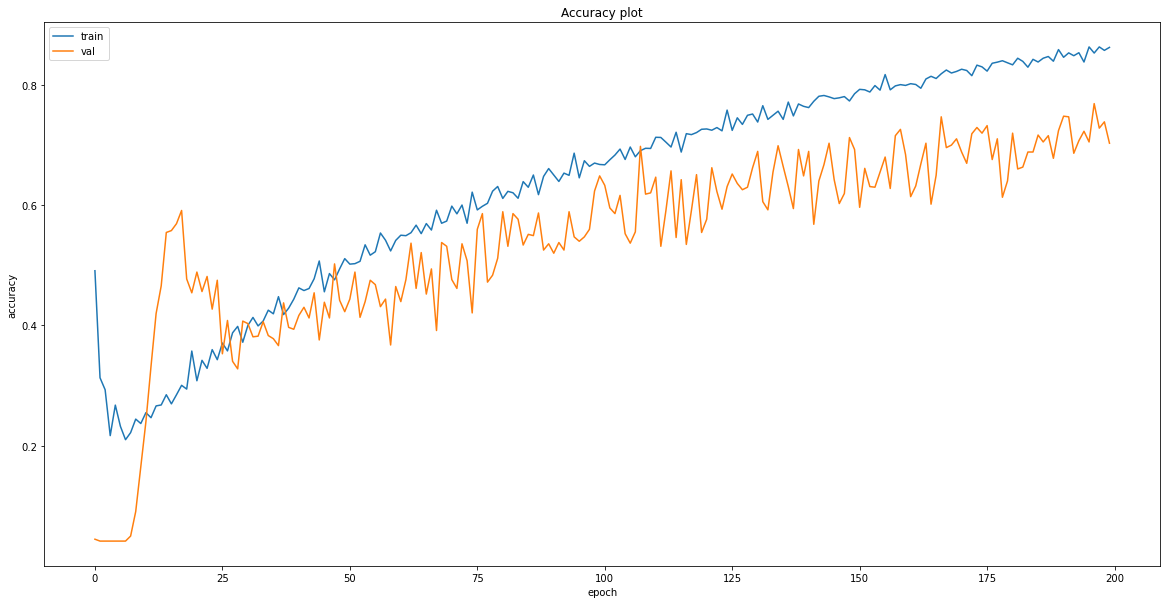

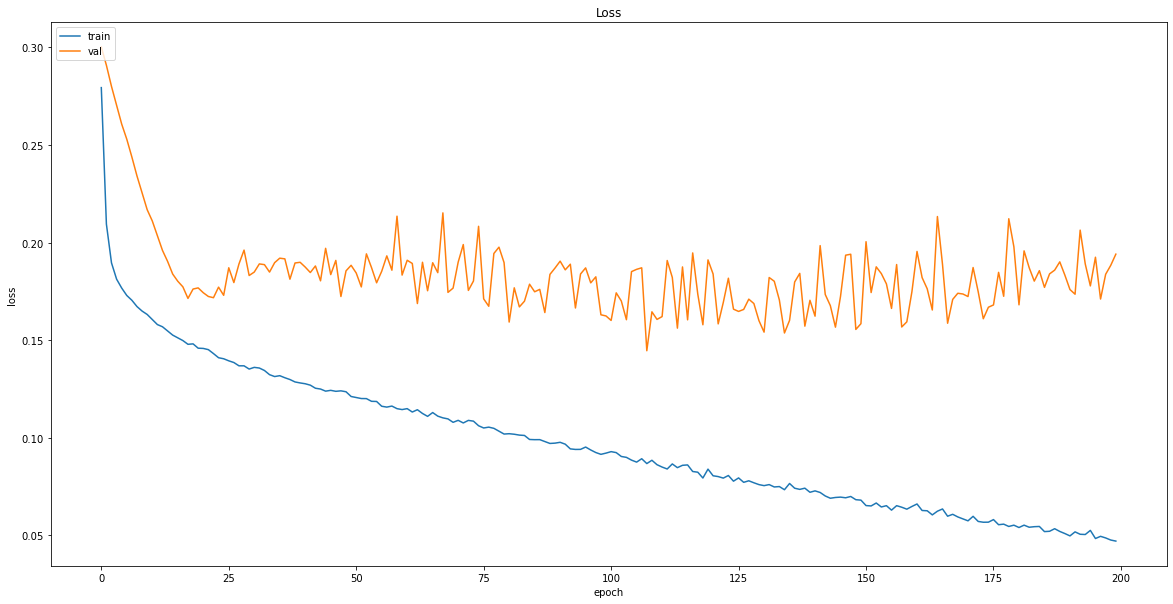

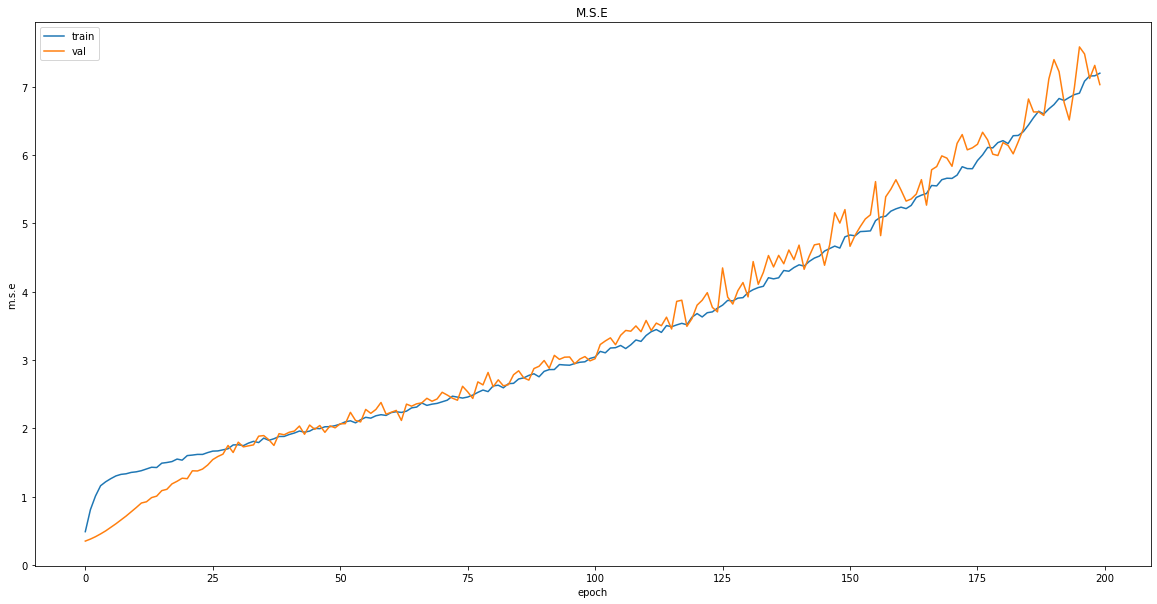

In [76]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('M.S.E')
plt.ylabel('m.s.e')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [77]:
# Save model
model.save("models/{}".format('ocbc_time_series_lstm_buy_hold_sell_no_close.model'))

INFO:tensorflow:Assets written to: models/ocbc_time_series_lstm_buy_hold_sell_no_close.model\assets


### Test Performance

### non-recession

In [78]:
logger = []

In [79]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-21        11.75  11.523654 -10.869606  21160951.0     2.0
2019-01-22        11.73  11.555399 -13.978517  18040951.0     2.0
2019-01-23        11.50  11.546876 -38.709667  14286851.0     1.0
2019-01-24        11.38  11.521203 -51.612890   8454651.0     2.0
2019-01-25        11.41  11.504095 -80.357185  12469051.0     2.0


In [80]:
df.drop(['previous_1d'], axis='columns', inplace=True)

In [81]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [82]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(218, 15, 3)

In [83]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [84]:
model = tf.keras.models.load_model("models/ocbc_time_series_lstm_buy_hold_sell_no_close.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.2027 - accuracy: 0.6927 - mean_squared_error: 7.7669 - weighted_accuracy: 0.6927 - weighted_mean_squared_error: 7.7669
Test loss: 0.20273934304714203
Test accuracy: 0.6926605701446533


In [85]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 160, 0: 34, 1: 24})

In [86]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 201, 0: 9, 1: 8})

In [87]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test.csv")
df.set_index('Date', inplace=True)

In [88]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,11.53,11.457507,-67.857228,17615658.0,2.0,2,2
2019-02-12,11.49,11.468659,-43.902530,20832858.0,2.0,2,2
2019-02-13,11.65,11.471942,-42.424356,17325458.0,2.0,0,2
2019-02-14,11.68,11.499336,-10.256417,22091358.0,2.0,2,2
2019-02-15,11.52,11.527130,-5.714153,24228358.0,2.0,2,2


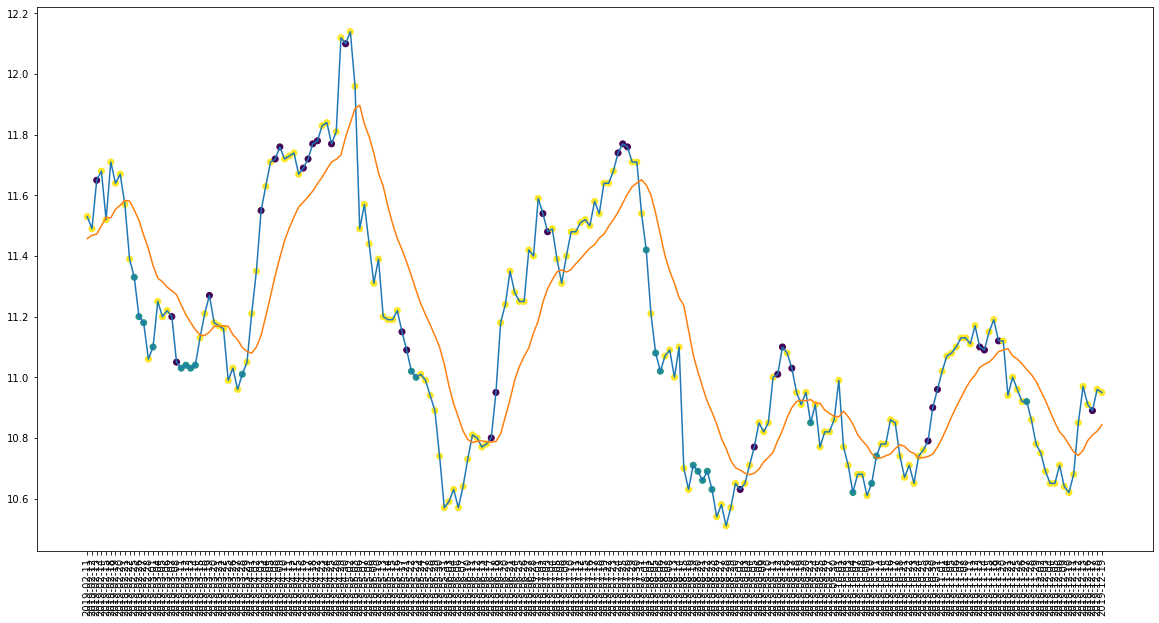

In [89]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

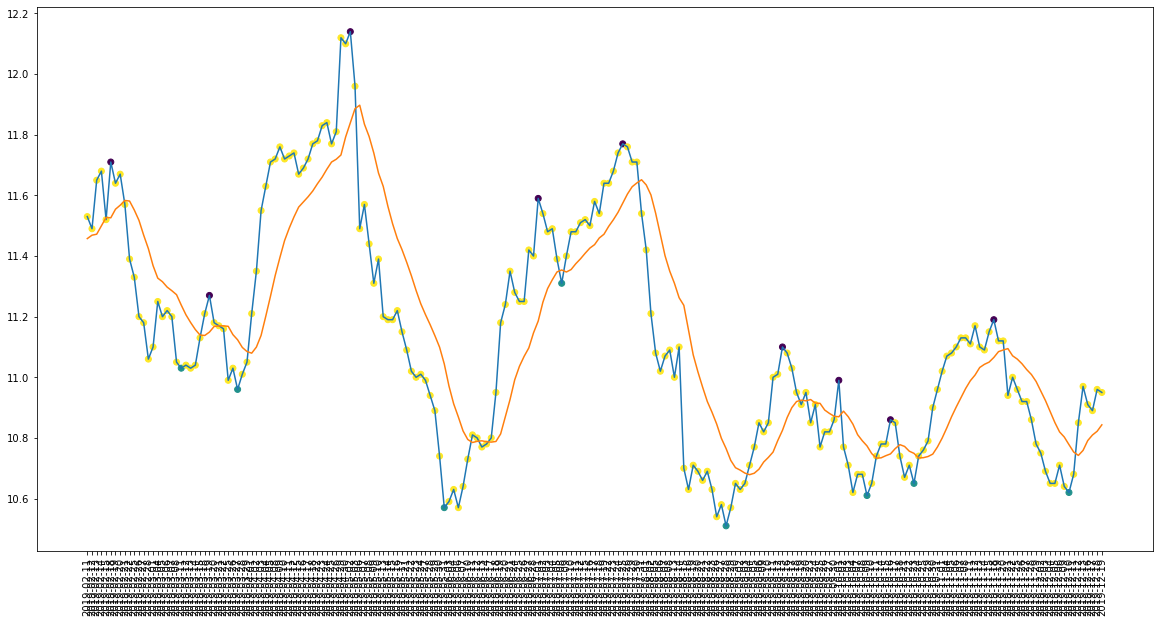

In [90]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [91]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 6
actual holds but predicted buy: 23
actual holds but predicted sell: 31
actual predicted holds: 147
Percentage buys correct: 12.5%
Percentage sells correct: 33.333333333333336%
Percentage holds correct: 73.13432835820896%
actual buys: 8
actual sells: 9
actual holds: 201


In [92]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[11.489999771118164, 11.520000457763672, 11.529999732971193, 11.56999969482422, 11.640000343322756, 11.649999618530273, 11.670000076293945, 11.68000030517578, 11.710000038146973]
[11.0600004196167, 11.100000381469727, 11.18000030517578, 11.199999809265137, 11.329999923706055, 11.390000343322756, 11.56999969482422, 11.640000343322756, 11.670000076293945]
Percentage buys correct: 58.333333333333336%
Percentage sells correct: 50.0%
Percentage holds correct: 86.16352201257861%


In [93]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $11.329999923706055
Shares owned at the moment: 880
Cash capital at the moment: $2.1814673233020585


Stop Loss Activated!

Share price: $10.989999771118164
Shares owned at the moment: 0
Cash capital at the moment: $9646.78546646118


Share price: $11.010000228881836
Shares owned at the moment: 873
Cash capital at the moment: $8.623008597849548


Price increase from previously bought: 6.156752159419043%
Share price: $11.720000267028807
Shares owned at the moment: 0
Cash capital at the moment: $10212.046451072927


Share price: $11.020000457763672
Shares owned at the moment: 924
Cash capital at the moment: $1.564206936116534


Stop Loss Activated!

Share price: $10.56999969482422
Shares owned at the moment: 0
Cash capital at the moment: $9741.385555729148


Share price: $11.420000076293945
Shares owned at the moment: 850
Cash capital at the moment: $7.691240700956769


Stop Loss Activated!

Share price: $11.079999923706056
Shares owned at the moment: 0
Cash capital at the m

In [94]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9445.467587005614
profit gained: -5.545324129943856%


In [95]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.733945,55.55555555555556%,22.22222222222222%,76.5%,59.375%,63.63636363636363%,81.70731707317073%,-11.565783517952005%,-7.777238176262399%
1,0.730233,25.0%,0.0%,78.28282828282828%,62.16216216216216%,55.55555555555556%,85.20710059171597%,-34.86491934328384%,-48.34563047105195%
2,0.692661,12.5%,33.333333333333336%,73.13432835820896%,58.333333333333336%,50.0%,86.16352201257861%,-8.207943820746005%,-5.545324129943856%


### recession

In [96]:
logger = []

In [97]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-01-22        11.12  11.072811 -24.444379  27489400.0     2.0
2020-01-23        11.19  11.090840  -8.888884  31751200.0     2.0
2020-01-24        11.11  11.093787 -26.666653  27359800.0     2.0
2020-01-28        11.10  11.094743 -28.888715  24699300.0     2.0
2020-01-29        10.90  11.064783 -71.739257  16499235.0     2.0


In [98]:
df.drop(['previous_1d'], axis='columns', inplace=True)

In [99]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [100]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(215, 15, 3)

In [101]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [102]:
model = tf.keras.models.load_model("models/ocbc_time_series_lstm_buy_hold_sell_no_close.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.2238 - accuracy: 0.7302 - mean_squared_error: 7.9242 - weighted_accuracy: 0.7302 - weighted_mean_squared_error: 7.9242
Test loss: 0.2238006293773651
Test accuracy: 0.7302325367927551


In [103]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 167, 1: 21, 0: 27})

In [104]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 193, 0: 10, 1: 12})

In [105]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test2.csv")
df.set_index('Date', inplace=True)

In [106]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-12,11.02,10.890637,-80.357049,13333200.0,2.0,2,2
2020-02-13,11.05,10.910539,-32.075322,21593100.0,2.0,2,2
2020-02-14,11.06,10.931995,-15.217324,25962500.0,2.0,2,2
2020-02-17,11.01,10.951688,-13.043361,29610200.0,2.0,2,2
2020-02-18,10.97,10.960659,-23.912967,27996300.0,2.0,2,2


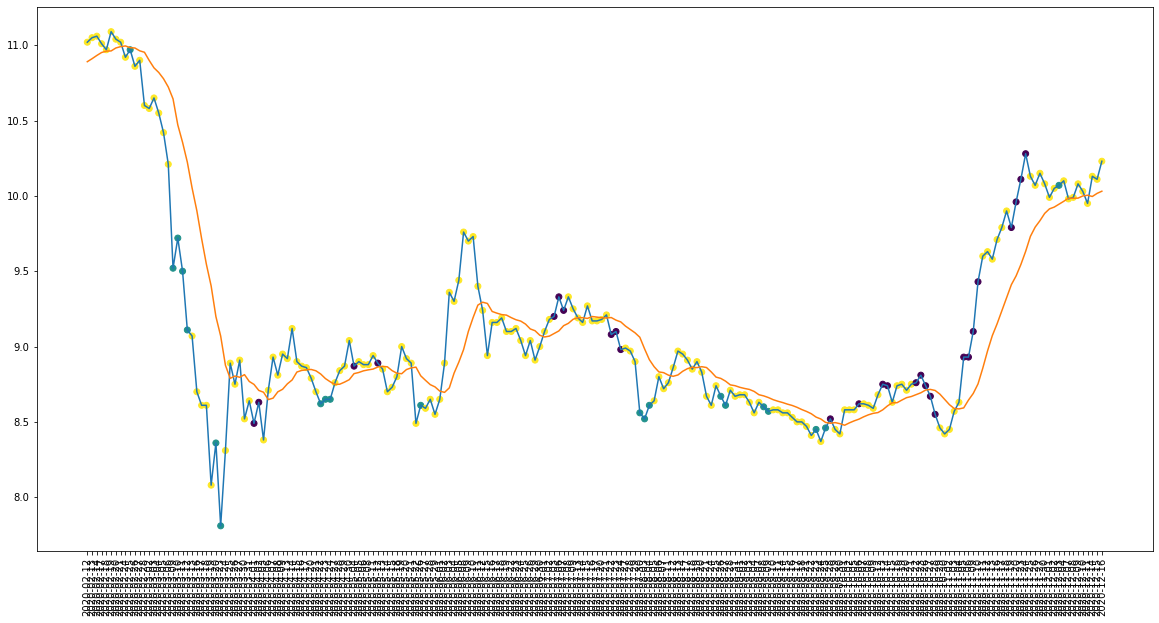

In [107]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

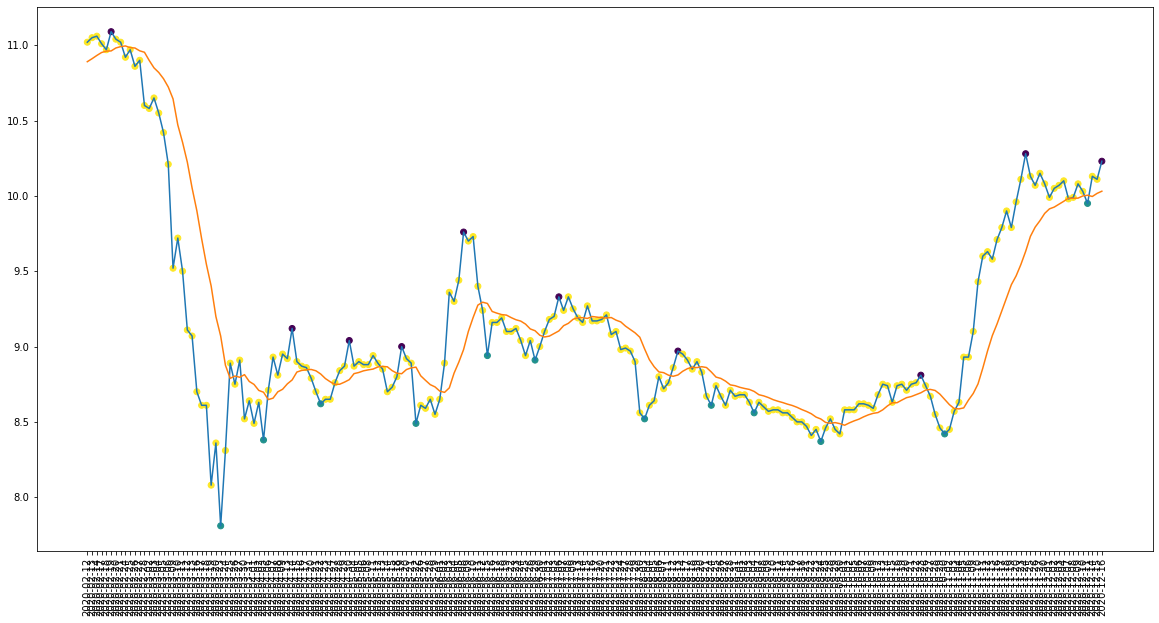

In [108]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [109]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 215
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 7
actual holds but predicted buy: 18
actual holds but predicted sell: 24
actual predicted holds: 151
Percentage buys correct: 25.0%
Percentage sells correct: 30.0%
Percentage holds correct: 78.23834196891191%
actual buys: 12
actual sells: 10
actual holds: 193


In [110]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[10.920000076293944, 10.970000267028807, 11.010000228881836, 11.020000457763672, 11.020000457763672, 11.039999961853027, 11.050000190734863, 11.0600004196167, 11.09000015258789]
[10.579999923706056, 10.600000381469727, 10.649999618530273, 10.859999656677246, 10.899999618530273, 10.920000076293944, 10.970000267028807, 11.020000457763672, 11.039999961853027]
Percentage buys correct: 66.66666666666667%
Percentage sells correct: 51.851851851851855%
Percentage holds correct: 86.74698795180723%


In [111]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $10.970000267028807
Shares owned at the moment: 909
Cash capital at the moment: $0.8474991033090191


Stop Loss Activated!

Share price: $10.600000381469727
Shares owned at the moment: 0
Cash capital at the moment: $9609.750494905711


Share price: $9.520000457763672
Shares owned at the moment: 1006
Cash capital at the moment: $6.292953129053785


Stop Loss Activated!

Share price: $9.109999656677246
Shares owned at the moment: 0
Cash capital at the moment: $9145.749793696166


Share price: $9.109999656677246
Shares owned at the moment: 1001
Cash capital at the moment: $1.5625858073235577


Stop Loss Activated!

Share price: $8.699999809265138
Shares owned at the moment: 0
Cash capital at the moment: $8686.313470406772


Share price: $8.359999656677246
Shares owned at the moment: 1036
Cash capital at the moment: $1.5361870672713849


Stop Loss Activated!

Share price: $7.809999942779541
Shares owned at the moment: 0
Cash capital at the moment: $8070.445437949897


Share pr

In [112]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9233.011672363282
profit gained: -7.669883276367181%


In [113]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.733945,55.55555555555556%,22.22222222222222%,76.5%,59.375%,63.63636363636363%,81.70731707317073%,-11.565783517952005%,-7.777238176262399%
1,0.730233,25.0%,0.0%,78.28282828282828%,62.16216216216216%,55.55555555555556%,85.20710059171597%,-34.86491934328384%,-48.34563047105195%
2,0.692661,12.5%,33.333333333333336%,73.13432835820896%,58.333333333333336%,50.0%,86.16352201257861%,-8.207943820746005%,-5.545324129943856%
3,0.730233,25.0%,30.0%,78.23834196891191%,66.66666666666667%,51.851851851851855%,86.74698795180723%,-1.0883829350662744%,-7.669883276367181%


## CNOOC Limited

In [125]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14       OBV_7  labels
0  2004-04-07        3.250  3.264699 -57.142857  31539206.0     2.0
1  2004-04-08        3.200  3.254745 -78.947368 -24878594.0     2.0
2  2004-04-13        3.250  3.254015 -52.631579  10937473.0     0.0
3  2004-04-14        3.375  3.272628 -10.416706  98972973.0     2.0
4  2004-04-15        3.275  3.272993 -52.083331  47190715.0     2.0


In [126]:
df.drop(['previous_1d'], axis='columns', inplace=True)

In [127]:
df.set_index('Date', inplace=True)
df.head()

,EMA_12,willr_14,OBV_7,labels
Date,,,,
2004-04-07,3.264699,-57.142857,31539206.0,2.0
2004-04-08,3.254745,-78.947368,-24878594.0,2.0
2004-04-13,3.254015,-52.631579,10937473.0,0.0
2004-04-14,3.272628,-10.416706,98972973.0,2.0
2004-04-15,3.272993,-52.083331,47190715.0,2.0


In [128]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1

In [129]:
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
X.shape

(3590, 15, 3)

In [130]:
y = labels
y = np.array(y)

In [131]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [132]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [133]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [134]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [135]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
23/23 [==============================] - 1s 37ms/step - loss: 0.2949 - accuracy: 0.5543 - mse: 0.4432 - weighted_accuracy: 0.3585 - weighted_mse: 0.5236 - val_loss: 0.3019 - val_accuracy: 0.0655 - val_mse: 0.3444 - val_weighted_accuracy: 0.0655 - val_weighted_mse: 0.3444
Epoch 2/200
23/23 [==============================] - 0s 7ms/step - loss: 0.2223 - accuracy: 0.4102 - mse: 0.7043 - weighted_accuracy: 0.4313 - weighted_mse: 0.7141 - val_loss: 0.2958 - val_accuracy: 0.0446 - val_mse: 0.3617 - val_weighted_accuracy: 0.0446 - val_weighted_mse: 0.3617
Epoch 3/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1980 - accuracy: 0.3259 - mse: 0.9250 - weighted_accuracy: 0.4996 - weighted_mse: 0.8964 - val_loss: 0.2884 - val_accuracy: 0.0446 - val_mse: 0.3854 - val_weighted_accuracy: 0.0446 - val_weighted_mse: 0.3854
Epoch 4/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1852 - accuracy: 0.3350 - mse: 1.0603 - weighted_accuracy: 0.5319 - weighte

Epoch 30/200
23/23 [==============================] - 0s 6ms/step - loss: 0.1390 - accuracy: 0.3907 - mse: 1.6517 - weighted_accuracy: 0.7018 - weighted_mse: 1.5624 - val_loss: 0.1745 - val_accuracy: 0.4554 - val_mse: 1.4527 - val_weighted_accuracy: 0.4554 - val_weighted_mse: 1.4527
Epoch 31/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1384 - accuracy: 0.4161 - mse: 1.6355 - weighted_accuracy: 0.7040 - weighted_mse: 1.5550 - val_loss: 0.1764 - val_accuracy: 0.4248 - val_mse: 1.5634 - val_weighted_accuracy: 0.4248 - val_weighted_mse: 1.5634
Epoch 32/200
23/23 [==============================] - 0s 6ms/step - loss: 0.1388 - accuracy: 0.4258 - mse: 1.6584 - weighted_accuracy: 0.7001 - weighted_mse: 1.5897 - val_loss: 0.1764 - val_accuracy: 0.4429 - val_mse: 1.5417 - val_weighted_accuracy: 0.4429 - val_weighted_mse: 1.5417
Epoch 33/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1366 - accuracy: 0.3813 - mse: 1.6983 - weighted_accuracy: 0.7080 - weig

Epoch 59/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1209 - accuracy: 0.4878 - mse: 2.0056 - weighted_accuracy: 0.7687 - weighted_mse: 1.9654 - val_loss: 0.1872 - val_accuracy: 0.4359 - val_mse: 2.1081 - val_weighted_accuracy: 0.4359 - val_weighted_mse: 2.1081
Epoch 60/200
23/23 [==============================] - 0s 6ms/step - loss: 0.1203 - accuracy: 0.5261 - mse: 1.9922 - weighted_accuracy: 0.7874 - weighted_mse: 1.9655 - val_loss: 0.1807 - val_accuracy: 0.4694 - val_mse: 2.0992 - val_weighted_accuracy: 0.4694 - val_weighted_mse: 2.0992
Epoch 61/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1200 - accuracy: 0.5066 - mse: 2.0274 - weighted_accuracy: 0.7635 - weighted_mse: 1.9979 - val_loss: 0.1795 - val_accuracy: 0.4694 - val_mse: 2.0307 - val_weighted_accuracy: 0.4694 - val_weighted_mse: 2.0307
Epoch 62/200
23/23 [==============================] - 0s 7ms/step - loss: 0.1200 - accuracy: 0.5178 - mse: 2.0567 - weighted_accuracy: 0.7749 - weig

Epoch 88/200
23/23 [==============================] - 0s 6ms/step - loss: 0.1054 - accuracy: 0.5992 - mse: 2.4116 - weighted_accuracy: 0.8169 - weighted_mse: 2.4316 - val_loss: 0.1804 - val_accuracy: 0.5042 - val_mse: 2.4662 - val_weighted_accuracy: 0.5042 - val_weighted_mse: 2.4662
Epoch 89/200
23/23 [==============================] - 0s 6ms/step - loss: 0.1037 - accuracy: 0.6003 - mse: 2.3995 - weighted_accuracy: 0.8221 - weighted_mse: 2.4467 - val_loss: 0.1687 - val_accuracy: 0.5529 - val_mse: 2.4290 - val_weighted_accuracy: 0.5529 - val_weighted_mse: 2.4290
Epoch 90/200
23/23 [==============================] - 0s 6ms/step - loss: 0.1029 - accuracy: 0.6194 - mse: 2.4193 - weighted_accuracy: 0.8267 - weighted_mse: 2.4584 - val_loss: 0.1825 - val_accuracy: 0.4972 - val_mse: 2.4974 - val_weighted_accuracy: 0.4972 - val_weighted_mse: 2.4974
Epoch 91/200
23/23 [==============================] - 0s 6ms/step - loss: 0.1066 - accuracy: 0.5759 - mse: 2.4472 - weighted_accuracy: 0.8132 - weig

Epoch 117/200
23/23 [==============================] - 0s 6ms/step - loss: 0.0891 - accuracy: 0.6675 - mse: 2.9337 - weighted_accuracy: 0.8539 - weighted_mse: 2.9992 - val_loss: 0.1544 - val_accuracy: 0.6435 - val_mse: 3.0633 - val_weighted_accuracy: 0.6435 - val_weighted_mse: 3.0633
Epoch 118/200
23/23 [==============================] - 0s 6ms/step - loss: 0.0884 - accuracy: 0.6884 - mse: 2.9272 - weighted_accuracy: 0.8640 - weighted_mse: 2.9803 - val_loss: 0.1807 - val_accuracy: 0.5501 - val_mse: 3.1219 - val_weighted_accuracy: 0.5501 - val_weighted_mse: 3.1219
Epoch 119/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0872 - accuracy: 0.6943 - mse: 2.9155 - weighted_accuracy: 0.8758 - weighted_mse: 2.9865 - val_loss: 0.1715 - val_accuracy: 0.5864 - val_mse: 3.0106 - val_weighted_accuracy: 0.5864 - val_weighted_mse: 3.0106
Epoch 120/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0864 - accuracy: 0.6936 - mse: 2.9918 - weighted_accuracy: 0.8755 - 

Epoch 146/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0746 - accuracy: 0.7441 - mse: 3.6440 - weighted_accuracy: 0.8941 - weighted_mse: 3.7132 - val_loss: 0.1707 - val_accuracy: 0.6142 - val_mse: 3.8538 - val_weighted_accuracy: 0.6142 - val_weighted_mse: 3.8538
Epoch 147/200
23/23 [==============================] - 0s 6ms/step - loss: 0.0739 - accuracy: 0.7521 - mse: 3.6446 - weighted_accuracy: 0.8970 - weighted_mse: 3.6844 - val_loss: 0.1708 - val_accuracy: 0.6281 - val_mse: 3.8122 - val_weighted_accuracy: 0.6281 - val_weighted_mse: 3.8122
Epoch 148/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0737 - accuracy: 0.7636 - mse: 3.7139 - weighted_accuracy: 0.8916 - weighted_mse: 3.7358 - val_loss: 0.1528 - val_accuracy: 0.6727 - val_mse: 3.9262 - val_weighted_accuracy: 0.6727 - val_weighted_mse: 3.9262
Epoch 149/200
23/23 [==============================] - 0s 6ms/step - loss: 0.0756 - accuracy: 0.7375 - mse: 3.7083 - weighted_accuracy: 0.8868 - 

Epoch 175/200
23/23 [==============================] - 0s 6ms/step - loss: 0.0688 - accuracy: 0.7608 - mse: 4.5899 - weighted_accuracy: 0.8930 - weighted_mse: 4.5580 - val_loss: 0.1662 - val_accuracy: 0.6755 - val_mse: 4.6660 - val_weighted_accuracy: 0.6755 - val_weighted_mse: 4.6660
Epoch 176/200
23/23 [==============================] - 0s 7ms/step - loss: 0.0618 - accuracy: 0.8012 - mse: 4.5587 - weighted_accuracy: 0.9223 - weighted_mse: 4.5758 - val_loss: 0.1564 - val_accuracy: 0.6978 - val_mse: 4.5814 - val_weighted_accuracy: 0.6978 - val_weighted_mse: 4.5814
Epoch 177/200
23/23 [==============================] - 0s 6ms/step - loss: 0.0628 - accuracy: 0.7960 - mse: 4.5509 - weighted_accuracy: 0.9155 - weighted_mse: 4.5656 - val_loss: 0.1596 - val_accuracy: 0.7089 - val_mse: 4.8825 - val_weighted_accuracy: 0.7089 - val_weighted_mse: 4.8825
Epoch 178/200
23/23 [==============================] - 0s 6ms/step - loss: 0.0608 - accuracy: 0.8200 - mse: 4.6284 - weighted_accuracy: 0.9172 - 

In [136]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

Test loss: 0.1666676253080368
Test accuracy: 0.7103064060211182


In [137]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-0.39880309 -4.2430134  -0.4363057 ]
 [-1.7111667  -1.7184632   0.2328053 ]
 [-3.4242392  -1.7356626   0.921574  ]
 ...
 [-4.694161   -1.3639507   0.7506251 ]
 [-1.576254   -4.300053    1.88098   ]
 [-2.9115298  -3.7941597   1.7244009 ]]


Counter({0: 104, 2: 553, 1: 61})

In [138]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 653, 0: 33, 1: 32})

In [139]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 718
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 28
actual sells but predicted buy: 0
actual predicted sells: 7
actual sells but predicted hold: 26
actual holds but predicted buy: 57
actual holds but predicted sell: 97
actual predicted holds: 499
Percentage buys correct: 12.5%
Percentage sells correct: 21.21212121212121%
Percentage holds correct: 76.41653905053599%
actual buys: 32
actual sells: 33
actual holds: 653


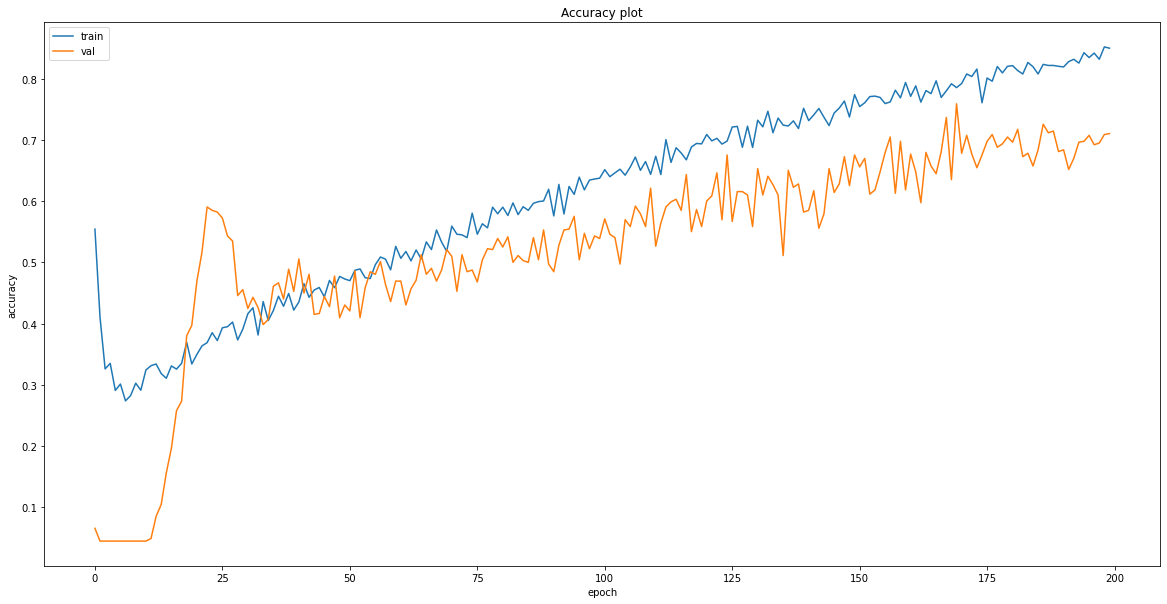

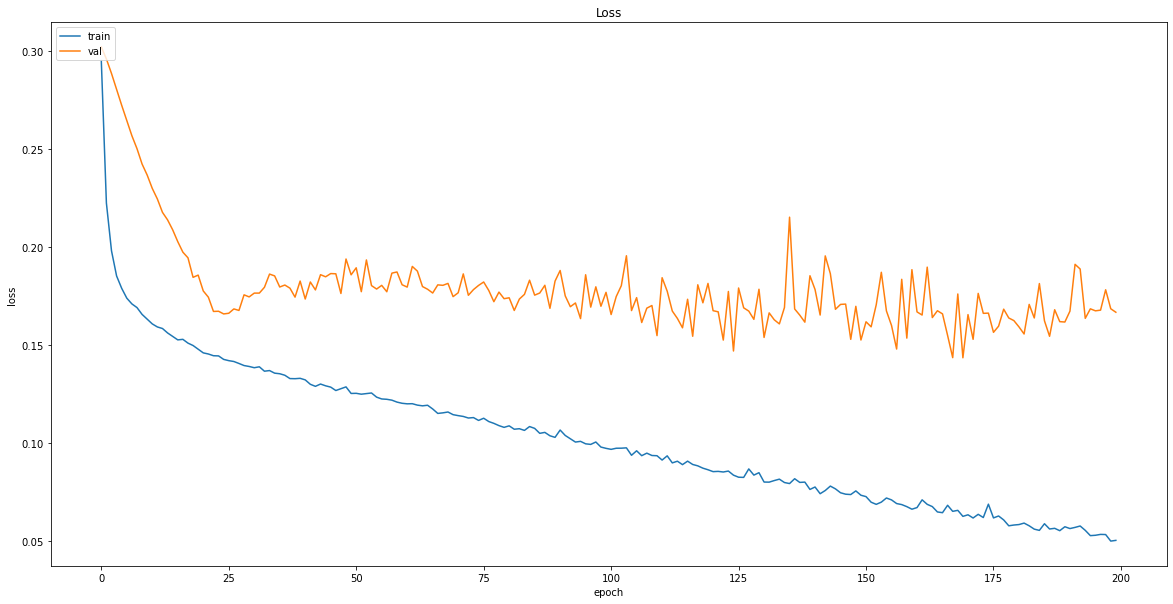

In [140]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [141]:
# Save model
model.save("models/{}".format('cnooc_time_series_lstm_buy_hold_sell_no_close.model'))

INFO:tensorflow:Assets written to: models/cnooc_time_series_lstm_buy_hold_sell_no_close.model\assets


### Test Performance

### non-recession

In [142]:
logger = []

In [143]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2019-01-22        13.12  12.552209  -3.030323  489168111.0     2.0
2019-01-23        12.94  12.611869 -13.043517  449876554.0     2.0
2019-01-24        12.62  12.613120 -33.333352  395082483.0     2.0
2019-01-25        12.80  12.641871 -37.254896  441807090.0     2.0
2019-01-28        13.06  12.706198 -11.764689  494043477.0     2.0


In [144]:
df.drop(['previous_1d'], axis='columns', inplace=True)

In [145]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(211, 15, 3)

In [146]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [147]:
model = tf.keras.models.load_model("models/cnooc_time_series_lstm_buy_hold_sell_no_close.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.2000 - accuracy: 0.6445 - mean_squared_error: 5.2519 - weighted_accuracy: 0.6445 - weighted_mean_squared_error: 5.2519
Test loss: 0.19999898970127106
Test accuracy: 0.6445497870445251


In [148]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 150, 0: 28, 1: 33})

In [149]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [150]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test.csv")
df.set_index('Date', inplace=True)

In [151]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-14,13.46,13.005887,-9.090899,594167146.0,2.0,2,2
2019-02-15,13.28,13.075751,-2.222168,636062191.0,2.0,2,2
2019-02-18,13.68,13.107174,-22.222210,601994876.0,2.0,0,2
2019-02-19,13.76,13.195301,-15.384598,654106730.0,2.0,0,2
2019-02-20,13.92,13.282178,-9.230759,687559434.0,2.0,2,2


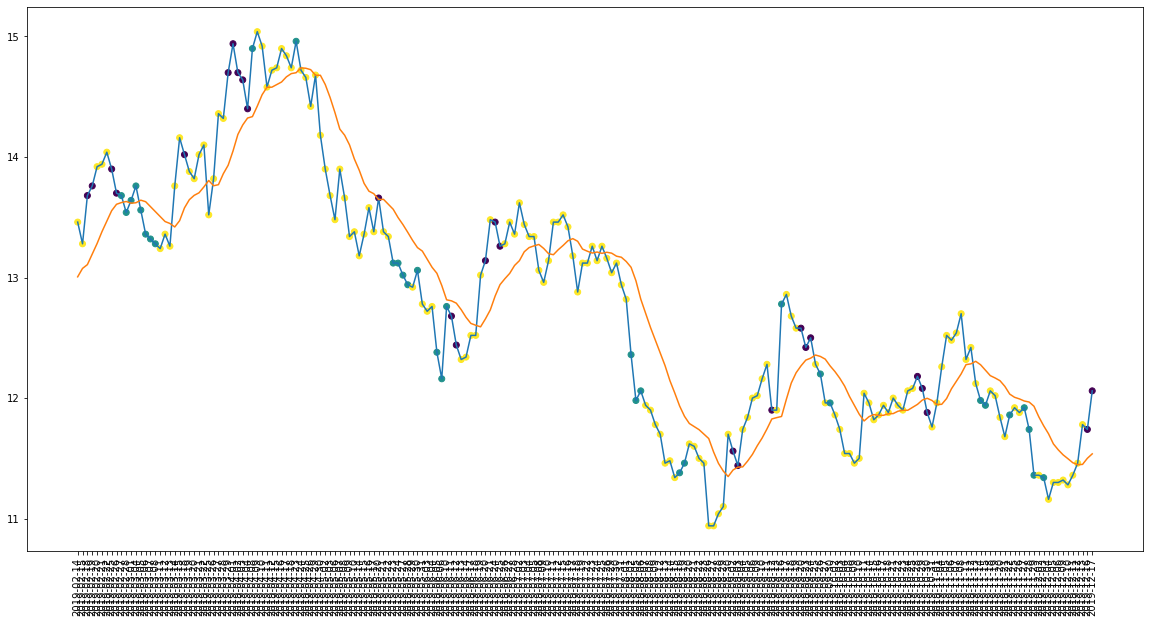

In [152]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

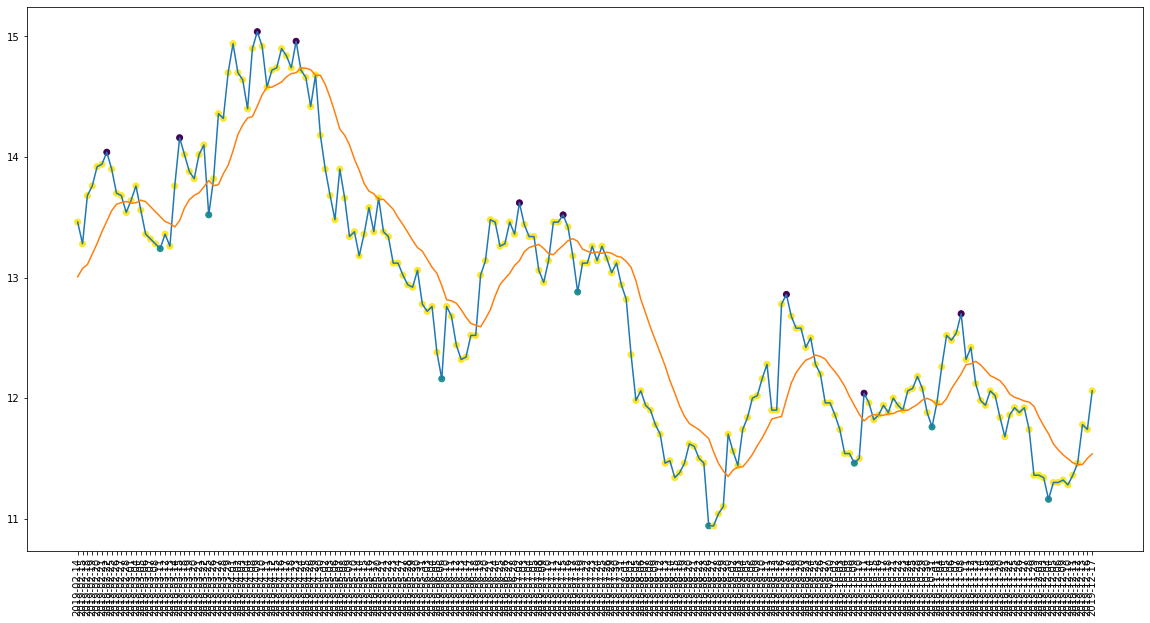

In [153]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [154]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 211
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 1
actual predicted sells: 0
actual sells but predicted hold: 8
actual holds but predicted buy: 31
actual holds but predicted sell: 28
actual predicted holds: 135
Percentage buys correct: 12.5%
Percentage sells correct: 0.0%
Percentage holds correct: 69.58762886597938%
actual buys: 8
actual sells: 9
actual holds: 194


In [155]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[13.279999732971193, 13.460000038146973, 13.68000030517578, 13.699999809265135, 13.760000228881836, 13.899999618530273, 13.920000076293945, 13.9399995803833, 14.039999961853027]
[13.359999656677244, 13.539999961853027, 13.5600004196167, 13.640000343322756, 13.68000030517578, 13.699999809265135, 13.760000228881836, 13.899999618530273, 14.039999961853027]
Percentage buys correct: 51.515151515151516%
Percentage sells correct: 51.851851851851855%
Percentage holds correct: 82.66666666666667%


In [156]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $13.68000030517578
Shares owned at the moment: 728
Cash capital at the moment: $13.572417221070282


Stop Loss Activated!

Share price: $13.279999732971193
Shares owned at the moment: 0
Cash capital at the moment: $9654.825663358692


Share price: $13.279999732971193
Shares owned at the moment: 725
Cash capital at the moment: $0.3488574869643344


Price increase from previously bought: 5.282767116875209%
Share price: $14.020000457763672
Shares owned at the moment: 0
Cash capital at the moment: $10136.89681345296


Share price: $14.899999618530273
Shares owned at the moment: 678
Cash capital at the moment: $6.916022800685823


Stop Loss Activated!

Share price: $14.420000076293945
Shares owned at the moment: 0
Cash capital at the moment: $9756.78998438573


Share price: $13.119999885559082
Shares owned at the moment: 741
Cash capital at the moment: $8.134789419651497


Stop Loss Activated!

Share price: $12.720000267028807
Shares owned at the moment: 0
Cash capital at the m

In [157]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $8912.067081356048
profit gained: -10.879329186439518%


In [158]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.733945,55.55555555555556%,22.22222222222222%,76.5%,59.375%,63.63636363636363%,81.70731707317073%,-11.565783517952005%,-7.777238176262399%
1,0.730233,25.0%,0.0%,78.28282828282828%,62.16216216216216%,55.55555555555556%,85.20710059171597%,-34.86491934328384%,-48.34563047105195%
2,0.692661,12.5%,33.333333333333336%,73.13432835820896%,58.333333333333336%,50.0%,86.16352201257861%,-8.207943820746005%,-5.545324129943856%
3,0.730233,25.0%,30.0%,78.23834196891191%,66.66666666666667%,51.851851851851855%,86.74698795180723%,-1.0883829350662744%,-7.669883276367181%
4,0.644550,12.5%,0.0%,69.58762886597938%,51.515151515151516%,51.851851851851855%,82.66666666666667%,-18.99364878754618%,-10.879329186439518%


### Recession

In [159]:
logger = []

In [160]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14        OBV_7  labels
Date                                                              
2020-01-22        13.00  13.393678 -83.870980  104646165.0     2.0
2020-01-23        13.34  13.385420 -57.377021  145802714.0     2.0
2020-01-24        13.00  13.326125 -85.245880   96260120.0     2.0
2020-01-29        13.04  13.282106 -80.645176  122828433.0     2.0
2020-01-30        12.46  13.155628 -90.804605   53693706.0     2.0


In [161]:
df.drop(['previous_1d'], axis='columns', inplace=True)

In [162]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(213, 15, 3)

In [163]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [164]:
model = tf.keras.models.load_model("models/cnooc_time_series_lstm_buy_hold_sell_no_close.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1532 - accuracy: 0.7512 - mean_squared_error: 5.3196 - weighted_accuracy: 0.7512 - weighted_mean_squared_error: 5.3196
Test loss: 0.15318968892097473
Test accuracy: 0.751173734664917


In [165]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 168, 1: 23, 0: 22})

In [166]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [167]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test2.csv")
df.set_index('Date', inplace=True)

In [168]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-13,12.34,12.385912,-50.526328,113135355.0,2.0,2,2
2020-02-14,12.34,12.378849,-50.588221,60757697.0,2.0,2,2
2020-02-17,12.26,12.372872,-46.153851,60757697.0,2.0,2,2
2020-02-18,12.00,12.355507,-38.709648,5146960.0,2.0,2,2
2020-02-19,12.08,12.300814,-59.677412,-52626865.0,2.0,2,2


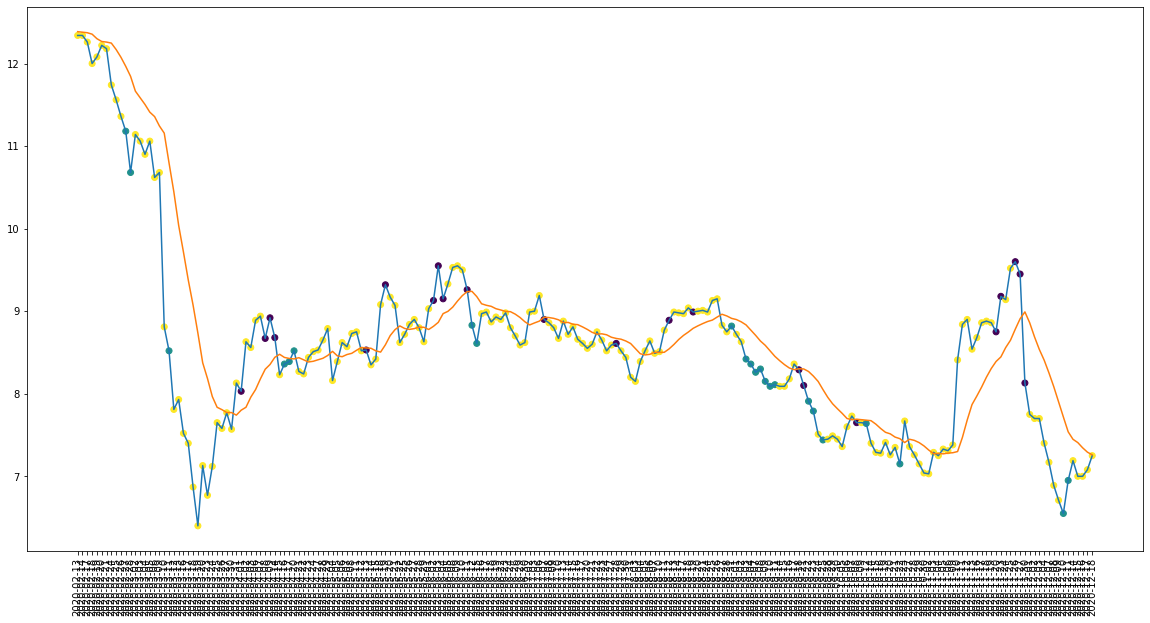

In [169]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

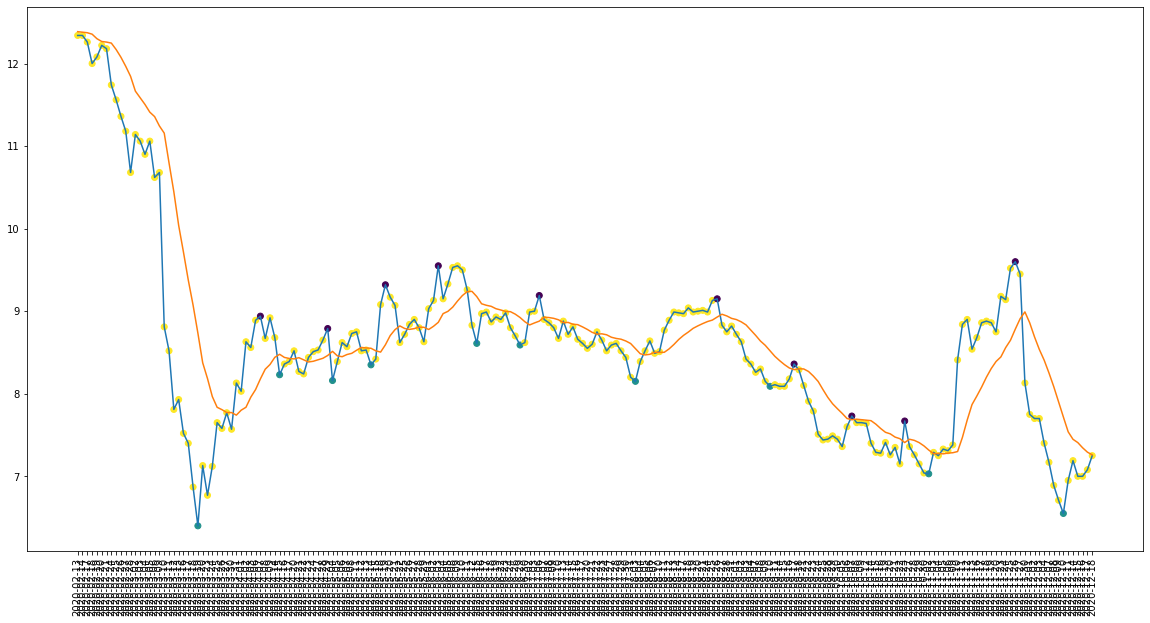

In [170]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [171]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 213
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 7
actual holds but predicted buy: 20
actual holds but predicted sell: 19
actual predicted holds: 154
Percentage buys correct: 30.0%
Percentage sells correct: 30.0%
Percentage holds correct: 79.79274611398964%
actual buys: 10
actual sells: 10
actual holds: 193


In [172]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[11.5600004196167, 11.739999771118164, 12.0, 12.079999923706055, 12.18000030517578, 12.220000267028807, 12.260000228881836, 12.34000015258789, 12.34000015258789]
[10.68000030517578, 10.899999618530273, 11.0600004196167, 11.140000343322754, 11.18000030517578, 11.359999656677244, 11.5600004196167, 11.739999771118164, 12.18000030517578]
Percentage buys correct: 47.82608695652174%
Percentage sells correct: 54.54545454545455%
Percentage holds correct: 82.63473053892216%


In [173]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $11.18000030517578
Shares owned at the moment: 892
Cash capital at the moment: $0.015187034608970862


Stop Loss Activated!

Share price: $10.68000030517578
Shares owned at the moment: 0
Cash capital at the moment: $9500.377418502807


Share price: $10.68000030517578
Shares owned at the moment: 887
Cash capital at the moment: $1.1659570674910356


Stop Loss Activated!

Share price: $8.8100004196167
Shares owned at the moment: 0
Cash capital at the moment: $7794.146535743953


Share price: $8.520000457763674
Shares owned at the moment: 912
Cash capital at the moment: $2.5379571154107907


Stop Loss Activated!

Share price: $7.809999942779541
Shares owned at the moment: 0
Cash capital at the moment: $7105.670425073861


Share price: $8.359999656677246
Shares owned at the moment: 847
Cash capital at the moment: $5.2781866679179075


Price increase from previously bought: 11.177516346453942%
Share price: $9.31999969482422
Shares owned at the moment: 0
Cash capital at the momen

In [174]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $5843.750896369933
profit gained: -41.56249103630067%


In [175]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.733945,55.55555555555556%,22.22222222222222%,76.5%,59.375%,63.63636363636363%,81.70731707317073%,-11.565783517952005%,-7.777238176262399%
1,0.730233,25.0%,0.0%,78.28282828282828%,62.16216216216216%,55.55555555555556%,85.20710059171597%,-34.86491934328384%,-48.34563047105195%
2,0.692661,12.5%,33.333333333333336%,73.13432835820896%,58.333333333333336%,50.0%,86.16352201257861%,-8.207943820746005%,-5.545324129943856%
3,0.730233,25.0%,30.0%,78.23834196891191%,66.66666666666667%,51.851851851851855%,86.74698795180723%,-1.0883829350662744%,-7.669883276367181%
4,0.644550,12.5%,0.0%,69.58762886597938%,51.515151515151516%,51.851851851851855%,82.66666666666667%,-18.99364878754618%,-10.879329186439518%
5,0.751174,30.0%,30.0%,79.79274611398964%,47.82608695652174%,54.54545454545455%,82.63473053892216%,-19.087250471389332%,-41.56249103630067%


## JP Morgan

In [176]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14       OBV_7  labels
0  2000-01-21    49.375000  48.388499 -42.592593  -2894250.0     2.0
1  2000-01-24    48.625000  48.424884 -39.516144  -8054850.0     2.0
2  2000-01-25    48.666668  48.462081 -38.709668  -1595700.0     2.0
3  2000-01-26    49.750000  48.660222 -17.741956   5984250.0     2.0
4  2000-01-27    52.291668  49.218906  -5.232557  14370900.0     2.0


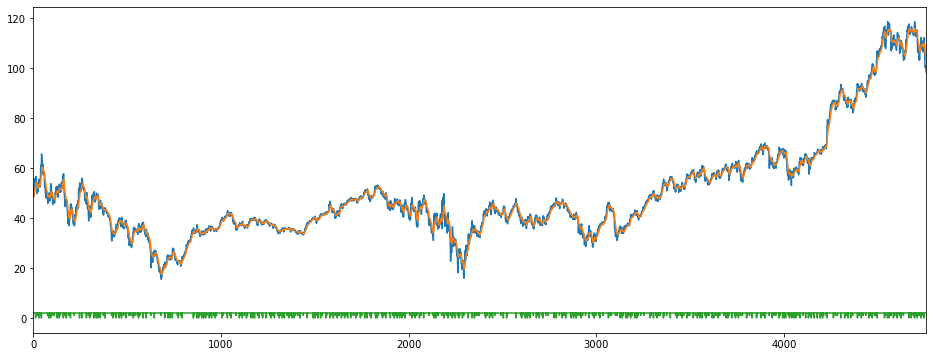

In [177]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [178]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,49.375000,48.388499,-42.592593,-2894250.0,2.0
2000-01-24,48.625000,48.424884,-39.516144,-8054850.0,2.0
2000-01-25,48.666668,48.462081,-38.709668,-1595700.0,2.0
2000-01-26,49.750000,48.660222,-17.741956,5984250.0,2.0
2000-01-27,52.291668,49.218906,-5.232557,14370900.0,2.0


In [179]:
df.drop(['previous_1d'], axis='columns', inplace=True)

In [180]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(4745, 15, 3)

In [181]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [182]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [183]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [184]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [185]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 32ms/step - loss: 0.2781 - accuracy: 0.4710 - mse: 0.4837 - weighted_accuracy: 0.3398 - weighted_mse: 0.5382 - val_loss: 0.3000 - val_accuracy: 0.0495 - val_mse: 0.3477 - val_weighted_accuracy: 0.0495 - val_weighted_mse: 0.3477
Epoch 2/200
30/30 [==============================] - 0s 7ms/step - loss: 0.2083 - accuracy: 0.3264 - mse: 0.8054 - weighted_accuracy: 0.4517 - weighted_mse: 0.7912 - val_loss: 0.2911 - val_accuracy: 0.0453 - val_mse: 0.3753 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.3753
Epoch 3/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1889 - accuracy: 0.2761 - mse: 1.0387 - weighted_accuracy: 0.4944 - weighted_mse: 1.0174 - val_loss: 0.2814 - val_accuracy: 0.0453 - val_mse: 0.4089 - val_weighted_accuracy: 0.0453 - val_weighted_mse: 0.4089
Epoch 4/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1809 - accuracy: 0.2437 - mse: 1.1657 - weighted_accuracy: 0.5201 - weighte

Epoch 30/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1421 - accuracy: 0.3754 - mse: 1.6521 - weighted_accuracy: 0.6803 - weighted_mse: 1.5678 - val_loss: 0.2028 - val_accuracy: 0.2803 - val_mse: 1.6907 - val_weighted_accuracy: 0.2803 - val_weighted_mse: 1.6907
Epoch 31/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1410 - accuracy: 0.3788 - mse: 1.6538 - weighted_accuracy: 0.6931 - weighted_mse: 1.5686 - val_loss: 0.2073 - val_accuracy: 0.2666 - val_mse: 1.6410 - val_weighted_accuracy: 0.2666 - val_weighted_mse: 1.6410
Epoch 32/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1411 - accuracy: 0.3883 - mse: 1.6751 - weighted_accuracy: 0.6982 - weighted_mse: 1.6055 - val_loss: 0.1956 - val_accuracy: 0.3361 - val_mse: 1.6233 - val_weighted_accuracy: 0.3361 - val_weighted_mse: 1.6233
Epoch 33/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1400 - accuracy: 0.3741 - mse: 1.6688 - weighted_accuracy: 0.6949 - weig

Epoch 59/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1217 - accuracy: 0.5158 - mse: 1.9996 - weighted_accuracy: 0.7811 - weighted_mse: 1.9476 - val_loss: 0.2105 - val_accuracy: 0.3815 - val_mse: 2.0999 - val_weighted_accuracy: 0.3815 - val_weighted_mse: 2.0999
Epoch 60/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1216 - accuracy: 0.5198 - mse: 2.0037 - weighted_accuracy: 0.7656 - weighted_mse: 1.9550 - val_loss: 0.1910 - val_accuracy: 0.4352 - val_mse: 2.1308 - val_weighted_accuracy: 0.4352 - val_weighted_mse: 2.1308
Epoch 61/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1219 - accuracy: 0.5011 - mse: 2.0080 - weighted_accuracy: 0.7738 - weighted_mse: 1.9538 - val_loss: 0.1957 - val_accuracy: 0.4183 - val_mse: 2.0069 - val_weighted_accuracy: 0.4183 - val_weighted_mse: 2.0069
Epoch 62/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1207 - accuracy: 0.5205 - mse: 2.0070 - weighted_accuracy: 0.7868 - weig

Epoch 88/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1041 - accuracy: 0.6088 - mse: 2.4420 - weighted_accuracy: 0.8284 - weighted_mse: 2.4240 - val_loss: 0.1919 - val_accuracy: 0.4773 - val_mse: 2.5869 - val_weighted_accuracy: 0.4773 - val_weighted_mse: 2.5869
Epoch 89/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1016 - accuracy: 0.6188 - mse: 2.4712 - weighted_accuracy: 0.8396 - weighted_mse: 2.4637 - val_loss: 0.1623 - val_accuracy: 0.5869 - val_mse: 2.6113 - val_weighted_accuracy: 0.5869 - val_weighted_mse: 2.6113
Epoch 90/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1017 - accuracy: 0.6085 - mse: 2.5439 - weighted_accuracy: 0.8283 - weighted_mse: 2.5404 - val_loss: 0.2070 - val_accuracy: 0.4468 - val_mse: 2.8248 - val_weighted_accuracy: 0.4468 - val_weighted_mse: 2.8248
Epoch 91/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1023 - accuracy: 0.6117 - mse: 2.5344 - weighted_accuracy: 0.8330 - weig

Epoch 117/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0857 - accuracy: 0.7007 - mse: 3.1353 - weighted_accuracy: 0.8754 - weighted_mse: 3.1177 - val_loss: 0.1878 - val_accuracy: 0.5574 - val_mse: 3.3434 - val_weighted_accuracy: 0.5574 - val_weighted_mse: 3.3434
Epoch 118/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0833 - accuracy: 0.6976 - mse: 3.2038 - weighted_accuracy: 0.8741 - weighted_mse: 3.1968 - val_loss: 0.1928 - val_accuracy: 0.5574 - val_mse: 3.3591 - val_weighted_accuracy: 0.5574 - val_weighted_mse: 3.3591
Epoch 119/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0853 - accuracy: 0.7165 - mse: 3.2029 - weighted_accuracy: 0.8793 - weighted_mse: 3.2272 - val_loss: 0.1725 - val_accuracy: 0.6101 - val_mse: 3.3681 - val_weighted_accuracy: 0.6101 - val_weighted_mse: 3.3681
Epoch 120/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0823 - accuracy: 0.7065 - mse: 3.1921 - weighted_accuracy: 0.8777 - 

Epoch 146/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0672 - accuracy: 0.7911 - mse: 4.0817 - weighted_accuracy: 0.9086 - weighted_mse: 4.0916 - val_loss: 0.1778 - val_accuracy: 0.6312 - val_mse: 4.0177 - val_weighted_accuracy: 0.6312 - val_weighted_mse: 4.0177
Epoch 147/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0703 - accuracy: 0.7803 - mse: 4.0697 - weighted_accuracy: 0.9045 - weighted_mse: 4.0522 - val_loss: 0.1891 - val_accuracy: 0.6417 - val_mse: 4.1905 - val_weighted_accuracy: 0.6417 - val_weighted_mse: 4.1905
Epoch 148/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0677 - accuracy: 0.7829 - mse: 4.1198 - weighted_accuracy: 0.9112 - weighted_mse: 4.0869 - val_loss: 0.1630 - val_accuracy: 0.6723 - val_mse: 4.6088 - val_weighted_accuracy: 0.6723 - val_weighted_mse: 4.6088
Epoch 149/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0677 - accuracy: 0.7869 - mse: 4.1705 - weighted_accuracy: 0.9087 - 

Epoch 175/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0543 - accuracy: 0.8448 - mse: 5.1875 - weighted_accuracy: 0.9338 - weighted_mse: 5.0563 - val_loss: 0.2145 - val_accuracy: 0.5943 - val_mse: 5.1364 - val_weighted_accuracy: 0.5943 - val_weighted_mse: 5.1364
Epoch 176/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0539 - accuracy: 0.8359 - mse: 5.1108 - weighted_accuracy: 0.9306 - weighted_mse: 4.9682 - val_loss: 0.2054 - val_accuracy: 0.6586 - val_mse: 5.6698 - val_weighted_accuracy: 0.6586 - val_weighted_mse: 5.6698
Epoch 177/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0544 - accuracy: 0.8422 - mse: 5.2663 - weighted_accuracy: 0.9290 - weighted_mse: 5.1065 - val_loss: 0.1746 - val_accuracy: 0.7144 - val_mse: 5.7681 - val_weighted_accuracy: 0.7144 - val_weighted_mse: 5.7681
Epoch 178/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0532 - accuracy: 0.8440 - mse: 5.3227 - weighted_accuracy: 0.9393 - 

In [186]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

Test loss: 0.17944474518299103
Test accuracy: 0.7397260069847107


In [187]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-0.14568739 -3.5610862  -0.4002755 ]
 [-3.8290122  -4.1971874   3.0374146 ]
 [-2.7545846  -6.72415     2.1805096 ]
 ...
 [-2.5745645  -2.7432423   1.2850804 ]
 [-0.1649373  -3.5397465  -0.60777664]
 [-0.7202988  -2.836927    0.1249712 ]]


Counter({0: 95, 2: 769, 1: 85})

In [188]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 865, 0: 41, 1: 43})

In [189]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 949
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 40
actual sells but predicted buy: 1
actual predicted sells: 5
actual sells but predicted hold: 35
actual holds but predicted buy: 81
actual holds but predicted sell: 90
actual predicted holds: 694
Percentage buys correct: 6.976744186046512%
Percentage sells correct: 12.195121951219512%
Percentage holds correct: 80.23121387283237%
actual buys: 43
actual sells: 41
actual holds: 865


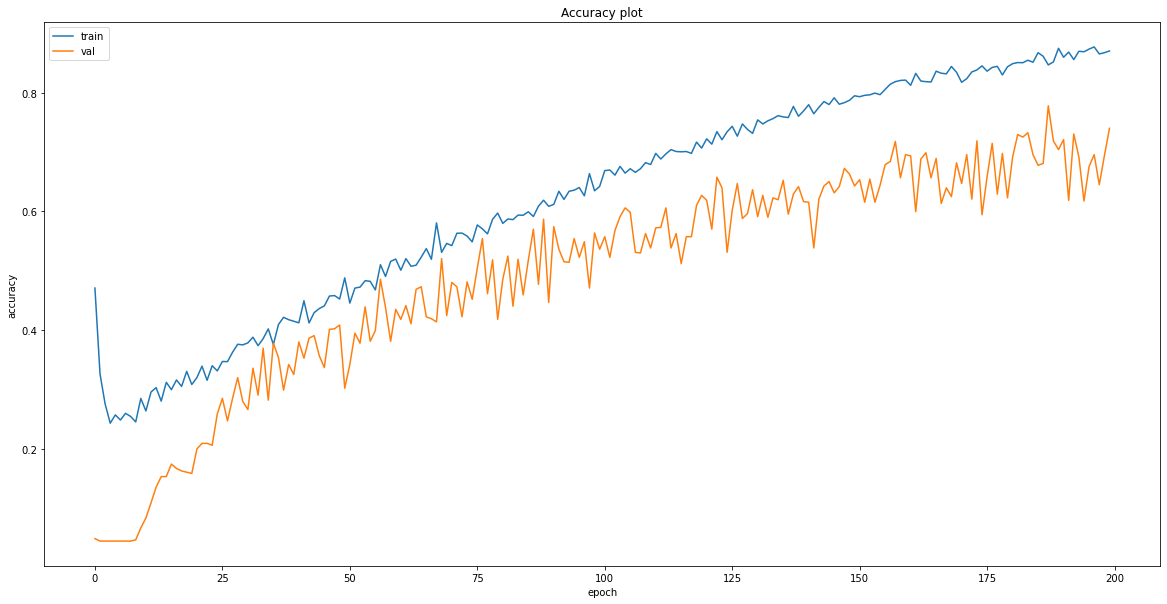

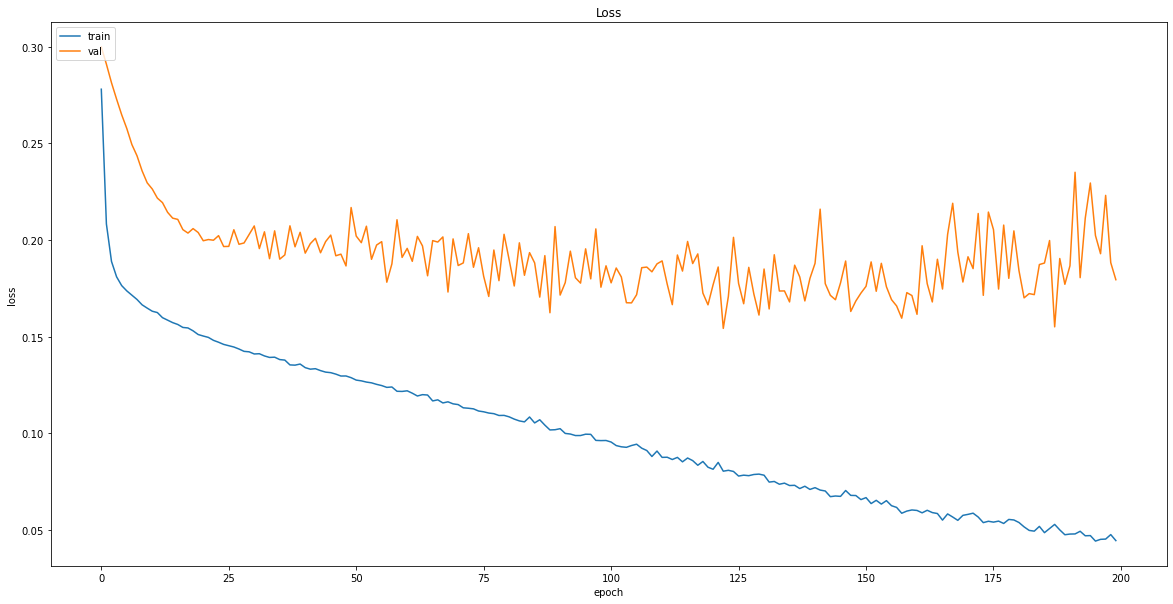

In [190]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [191]:
# Save model
model.save("models/{}".format('jpm_time_series_lstm_buy_hold_sell_no_close.model'))

INFO:tensorflow:Assets written to: models/jpm_time_series_lstm_buy_hold_sell_no_close.model\assets


### Test Performance

### non-recession

In [192]:
logger = []

In [193]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2019-01-22   104.589996  101.198442  -3.459880  84335200.0     2.0
2019-01-23   102.940002  101.466374 -21.874992  67251500.0     2.0
2019-01-24   102.680000  101.653086 -27.040213  55104800.0     2.0
2019-01-25   102.739998  101.820303 -32.628441  66401600.0     2.0
2019-01-28   103.389999  102.061795 -23.968276  80771000.0     2.0


In [194]:
df.drop(['previous_1d'], axis='columns', inplace=True)

In [195]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(218, 15, 3)

In [196]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [197]:
model = tf.keras.models.load_model("models/jpm_time_series_lstm_buy_hold_sell_no_close.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1513 - accuracy: 0.7661 - mean_squared_error: 6.5567 - weighted_accuracy: 0.7661 - weighted_mean_squared_error: 6.5567
Test loss: 0.15126240253448486
Test accuracy: 0.7660550475120544


In [198]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({1: 20, 2: 172, 0: 26})

In [199]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [200]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test.csv")
df.set_index('Date', inplace=True)

In [201]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,100.879997,102.975915,-74.903417,73097300.0,1.0,1,1
2019-02-12,102.599998,102.653466,-84.169891,62118800.0,2.0,1,2
2019-02-13,103.089996,102.645240,-50.965236,74971100.0,2.0,2,2
2019-02-14,102.419998,102.713664,-41.505819,85725200.0,2.0,2,2
2019-02-15,105.550003,102.668485,-54.440145,74206700.0,2.0,2,2


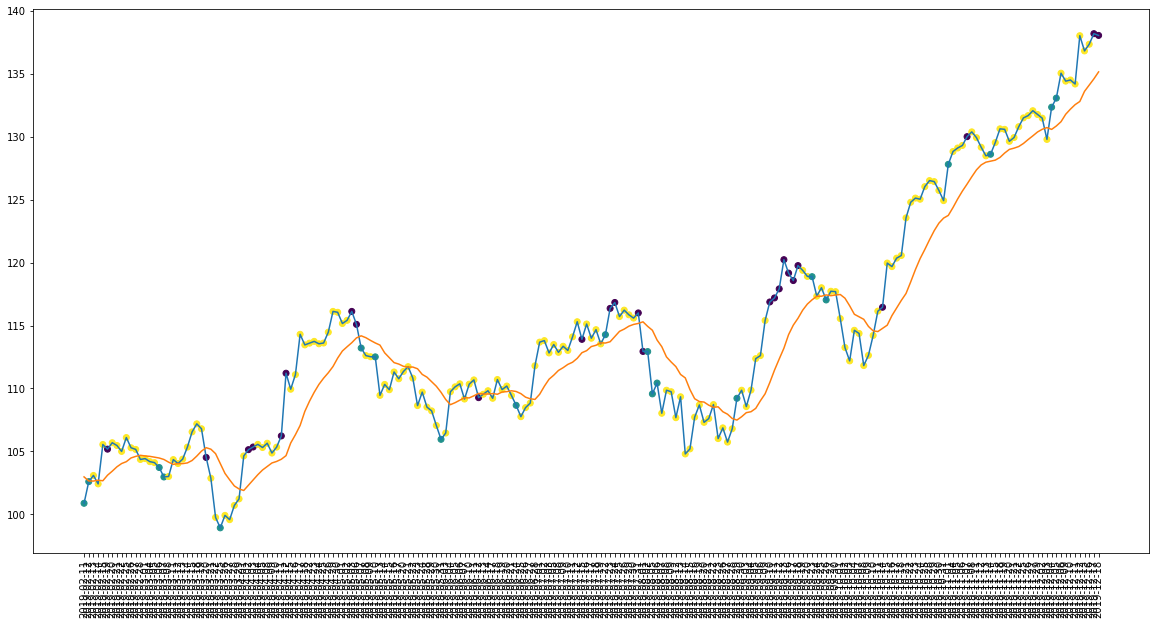

In [202]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

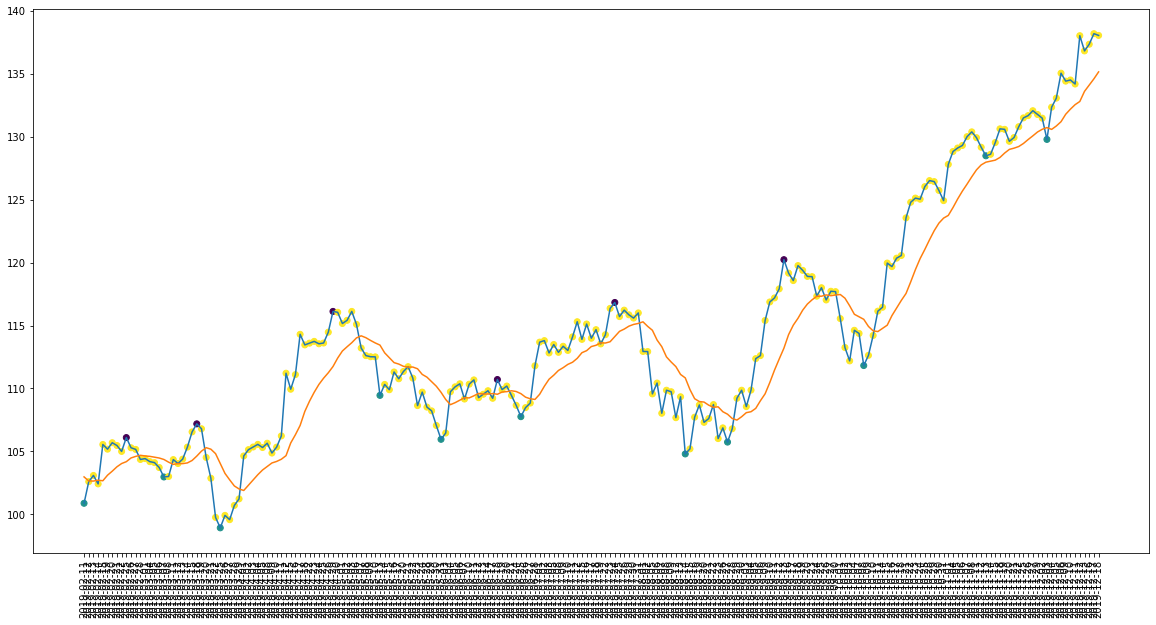

In [203]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [204]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 4
actual holds but predicted buy: 16
actual holds but predicted sell: 24
actual predicted holds: 161
Percentage buys correct: 36.36363636363637%
Percentage sells correct: 33.333333333333336%
Percentage holds correct: 80.09950248756219%
actual buys: 11
actual sells: 6
actual holds: 201


In [205]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[100.87999725341795, 102.41999816894531, 102.5999984741211, 103.08999633789062, 105.0, 105.18000030517578, 105.47000122070312, 105.5500030517578, 105.69000244140624]
[104.19000244140624, 104.36000061035156, 104.43000030517578, 105.0, 105.16000366210938, 105.29000091552734, 105.47000122070312, 105.69000244140624, 106.0999984741211]
Percentage buys correct: 55.0%
Percentage sells correct: 48.0%
Percentage holds correct: 86.62790697674419%


In [206]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $100.87999725341795
Shares owned at the moment: 98
Cash capital at the moment: $86.57310990524456


Price increase from previously bought: 5.014546880669868%
Share price: $106.2300033569336
Shares owned at the moment: 0
Cash capital at the moment: $10468.484452980043


Share price: $113.20999908447266
Shares owned at the moment: 92
Cash capital at the moment: $24.522407440186726


Stop Loss Activated!

Share price: $109.4499969482422
Shares owned at the moment: 0
Cash capital at the moment: $10066.231277450564


Share price: $105.95999908447266
Shares owned at the moment: 94
Cash capital at the moment: $78.6007037467989


Price increase from previously bought: 7.198599952443296%
Share price: $113.9000015258789
Shares owned at the moment: 0
Cash capital at the moment: $10755.757696784976


Share price: $114.2699966430664
Shares owned at the moment: 93
Cash capital at the moment: $99.42345733833645


Stop Loss Activated!

Share price: $109.56999969482422
Shares owned at the 

In [207]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $13577.290673755644
profit gained: 35.77290673755644%


In [208]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.733945,55.55555555555556%,22.22222222222222%,76.5%,59.375%,63.63636363636363%,81.70731707317073%,-11.565783517952005%,-7.777238176262399%
1,0.730233,25.0%,0.0%,78.28282828282828%,62.16216216216216%,55.55555555555556%,85.20710059171597%,-34.86491934328384%,-48.34563047105195%
2,0.692661,12.5%,33.333333333333336%,73.13432835820896%,58.333333333333336%,50.0%,86.16352201257861%,-8.207943820746005%,-5.545324129943856%
3,0.730233,25.0%,30.0%,78.23834196891191%,66.66666666666667%,51.851851851851855%,86.74698795180723%,-1.0883829350662744%,-7.669883276367181%
4,0.644550,12.5%,0.0%,69.58762886597938%,51.515151515151516%,51.851851851851855%,82.66666666666667%,-18.99364878754618%,-10.879329186439518%
5,0.751174,30.0%,30.0%,79.79274611398964%,47.82608695652174%,54.54545454545455%,82.63473053892216%,-19.087250471389332%,-41.56249103630067%
6,0.766055,36.36363636363637%,33.333333333333336%,80.09950248756219%,55.0%,48.0%,86.62790697674419%,7.952803013324737%,35.77290673755644%


### recession

In [209]:
logger = []

In [210]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d      EMA_12   willr_14       OBV_7  labels
Date                                                              
2020-01-22   136.839996  137.690058 -77.454723  33776700.0     2.0
2020-01-23   136.679993  137.534664 -80.363881  26227600.0     2.0
2020-01-24   136.539993  137.381637 -69.867648  16881900.0     2.0
2020-01-27   133.149994  136.730615 -90.166021   1715500.0     1.0
2020-01-28   132.029999  136.007444 -79.004573 -11145000.0     2.0


In [211]:
df.drop(['previous_1d'], axis='columns', inplace=True)

In [212]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(219, 15, 3)

In [213]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [214]:
model = tf.keras.models.load_model("models/jpm_time_series_lstm_buy_hold_sell_no_close.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.2050 - accuracy: 0.7626 - mean_squared_error: 7.2433 - weighted_accuracy: 0.7626 - weighted_mean_squared_error: 7.2433
Test loss: 0.2049700915813446
Test accuracy: 0.7625570893287659


In [215]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 184, 1: 17, 0: 18})

In [216]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [217]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test2.csv")
df.set_index('Date', inplace=True)

In [218]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,138.000000,136.179383,-6.410124,26757600.0,0.0,2,0
2020-02-12,138.000000,136.459478,-9.001177,33336200.0,2.0,2,2
2020-02-13,137.880005,136.696481,-13.465502,33336200.0,2.0,2,2
2020-02-14,137.460007,136.878562,-14.718062,25888700.0,2.0,2,2
2020-02-18,135.639999,136.968015,-23.401387,19261100.0,2.0,2,2


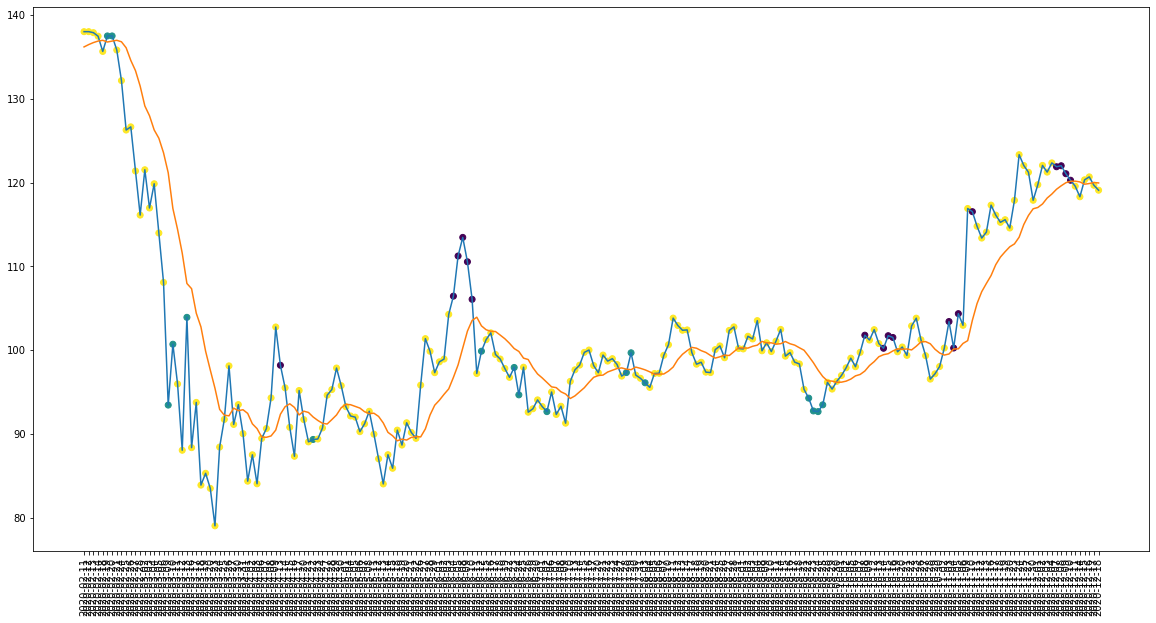

In [219]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

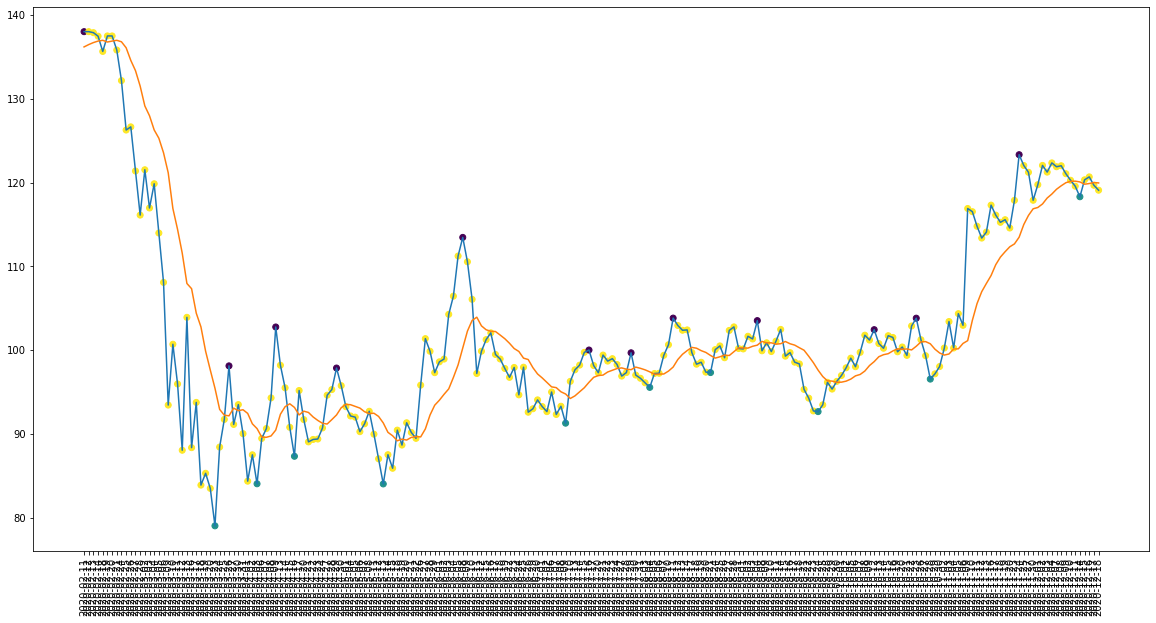

In [220]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [221]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 1
actual predicted sells: 1
actual sells but predicted hold: 10
actual holds but predicted buy: 15
actual holds but predicted sell: 17
actual predicted holds: 165
Percentage buys correct: 10.0%
Percentage sells correct: 8.333333333333334%
Percentage holds correct: 83.75634517766497%
actual buys: 10
actual sells: 12
actual holds: 197


In [222]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[132.16000366210938, 135.63999938964844, 135.80999755859378, 137.46000671386722, 137.49000549316406, 137.49000549316406, 137.8800048828125, 138.0, 138.0]
[116.11000061035156, 116.95999908447266, 121.37000274658205, 121.5199966430664, 126.26000213623048, 126.63999938964844, 132.16000366210938, 135.80999755859378, 137.49000549316406]
Percentage buys correct: 58.8235294117647%
Percentage sells correct: 72.22222222222223%
Percentage holds correct: 81.4207650273224%


In [223]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $137.49000549316406
Shares owned at the moment: 72
Cash capital at the moment: $73.49658340454152


Stop Loss Activated!

Share price: $132.16000366210938
Shares owned at the moment: 0
Cash capital at the moment: $9562.849166351318


Share price: $93.44000244140624
Shares owned at the moment: 102
Cash capital at the moment: $5.758996643067803


Stop Loss Activated!

Share price: $88.05000305175781
Shares owned at the moment: 0
Cash capital at the moment: $8962.161282066347


Share price: $103.91000366210938
Shares owned at the moment: 86
Cash capital at the moment: $1.3262512588516984


Stop Loss Activated!

Share price: $88.36000061035156
Shares owned at the moment: 0
Cash capital at the moment: $7579.389163604737


Share price: $89.33999633789062
Shares owned at the moment: 84
Cash capital at the moment: $54.191932067871676


Stop Loss Activated!

Share price: $84.02999877929688
Shares owned at the moment: 0
Cash capital at the moment: $7093.300899810792


Share price: $

In [224]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $8586.858291473387
profit gained: -14.13141708526613%


In [225]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.733945,55.55555555555556%,22.22222222222222%,76.5%,59.375%,63.63636363636363%,81.70731707317073%,-11.565783517952005%,-7.777238176262399%
1,0.730233,25.0%,0.0%,78.28282828282828%,62.16216216216216%,55.55555555555556%,85.20710059171597%,-34.86491934328384%,-48.34563047105195%
2,0.692661,12.5%,33.333333333333336%,73.13432835820896%,58.333333333333336%,50.0%,86.16352201257861%,-8.207943820746005%,-5.545324129943856%
3,0.730233,25.0%,30.0%,78.23834196891191%,66.66666666666667%,51.851851851851855%,86.74698795180723%,-1.0883829350662744%,-7.669883276367181%
4,0.644550,12.5%,0.0%,69.58762886597938%,51.515151515151516%,51.851851851851855%,82.66666666666667%,-18.99364878754618%,-10.879329186439518%
5,0.751174,30.0%,30.0%,79.79274611398964%,47.82608695652174%,54.54545454545455%,82.63473053892216%,-19.087250471389332%,-41.56249103630067%
6,0.766055,36.36363636363637%,33.333333333333336%,80.09950248756219%,55.0%,48.0%,86.62790697674419%,7.952803013324737%,35.77290673755644%
7,0.762557,10.0%,8.333333333333334%,83.75634517766497%,58.8235294117647%,72.22222222222223%,81.4207650273224%,-34.76409514123919%,-14.13141708526613%


## American Axle & Manufacturing Holdings, Inc

In [226]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14     OBV_7  labels
0  2000-01-21      16.0625  14.895987 -18.478261  298700.0     2.0
1  2000-01-24      15.8750  15.046605 -22.222222  293100.0     2.0
2  2000-01-25      15.7500  15.154819 -26.190476  286300.0     2.0
3  2000-01-26      15.7500  15.246386 -29.729730  286300.0     2.0
4  2000-01-27      16.0000  15.362326 -25.000000  311700.0     0.0


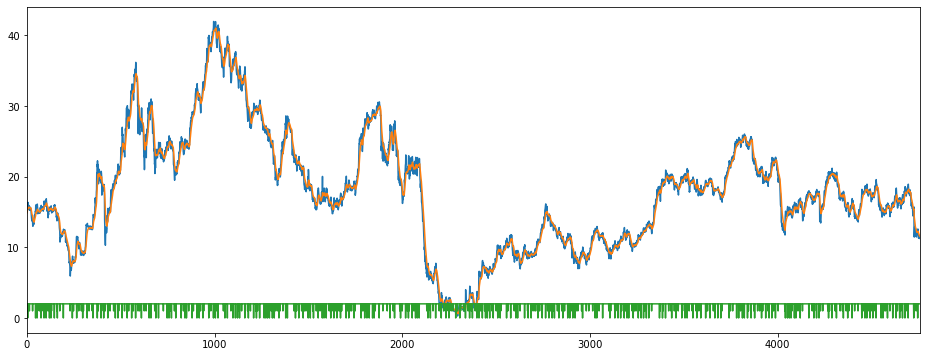

In [227]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [228]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,16.0625,14.895987,-18.478261,298700.0,2.0
2000-01-24,15.8750,15.046605,-22.222222,293100.0,2.0
2000-01-25,15.7500,15.154819,-26.190476,286300.0,2.0
2000-01-26,15.7500,15.246386,-29.729730,286300.0,2.0
2000-01-27,16.0000,15.362326,-25.000000,311700.0,0.0


In [229]:
df.drop(['previous_1d'], axis='columns', inplace=True)

In [230]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(4745, 15, 3)

In [231]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [232]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [233]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [234]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [235]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 31ms/step - loss: 0.2804 - accuracy: 0.5063 - mse: 0.4834 - weighted_accuracy: 0.3537 - weighted_mse: 0.5586 - val_loss: 0.3005 - val_accuracy: 0.0558 - val_mse: 0.3486 - val_weighted_accuracy: 0.0558 - val_weighted_mse: 0.3486
Epoch 2/200
30/30 [==============================] - 0s 8ms/step - loss: 0.2090 - accuracy: 0.3259 - mse: 0.8065 - weighted_accuracy: 0.4244 - weighted_mse: 0.8078 - val_loss: 0.2913 - val_accuracy: 0.0464 - val_mse: 0.3782 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.3782
Epoch 3/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1908 - accuracy: 0.2655 - mse: 1.0136 - weighted_accuracy: 0.4588 - weighted_mse: 0.9986 - val_loss: 0.2814 - val_accuracy: 0.0464 - val_mse: 0.4130 - val_weighted_accuracy: 0.0464 - val_weighted_mse: 0.4130
Epoch 4/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1825 - accuracy: 0.2503 - mse: 1.1349 - weighted_accuracy: 0.5097 - weighte

Epoch 30/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1414 - accuracy: 0.3788 - mse: 1.5720 - weighted_accuracy: 0.6882 - weighted_mse: 1.4883 - val_loss: 0.1865 - val_accuracy: 0.3899 - val_mse: 1.5467 - val_weighted_accuracy: 0.3899 - val_weighted_mse: 1.5467
Epoch 31/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1411 - accuracy: 0.4044 - mse: 1.5725 - weighted_accuracy: 0.6866 - weighted_mse: 1.4951 - val_loss: 0.1936 - val_accuracy: 0.3372 - val_mse: 1.5681 - val_weighted_accuracy: 0.3372 - val_weighted_mse: 1.5681
Epoch 32/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1402 - accuracy: 0.3609 - mse: 1.6245 - weighted_accuracy: 0.6925 - weighted_mse: 1.5296 - val_loss: 0.1908 - val_accuracy: 0.3815 - val_mse: 1.5190 - val_weighted_accuracy: 0.3815 - val_weighted_mse: 1.5190
Epoch 33/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1398 - accuracy: 0.3965 - mse: 1.6110 - weighted_accuracy: 0.6964 - weig

Epoch 59/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1207 - accuracy: 0.5313 - mse: 1.9615 - weighted_accuracy: 0.7606 - weighted_mse: 1.9360 - val_loss: 0.1891 - val_accuracy: 0.4447 - val_mse: 2.0589 - val_weighted_accuracy: 0.4447 - val_weighted_mse: 2.0589
Epoch 60/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1191 - accuracy: 0.5042 - mse: 2.0076 - weighted_accuracy: 0.7670 - weighted_mse: 1.9931 - val_loss: 0.1910 - val_accuracy: 0.4405 - val_mse: 2.1144 - val_weighted_accuracy: 0.4405 - val_weighted_mse: 2.1144
Epoch 61/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1187 - accuracy: 0.5648 - mse: 1.9810 - weighted_accuracy: 0.7893 - weighted_mse: 1.9722 - val_loss: 0.1838 - val_accuracy: 0.4552 - val_mse: 1.9870 - val_weighted_accuracy: 0.4552 - val_weighted_mse: 1.9870
Epoch 62/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1179 - accuracy: 0.5263 - mse: 2.0012 - weighted_accuracy: 0.7733 - weig

Epoch 88/200
30/30 [==============================] - 0s 7ms/step - loss: 0.1012 - accuracy: 0.6320 - mse: 2.4213 - weighted_accuracy: 0.8467 - weighted_mse: 2.4671 - val_loss: 0.1766 - val_accuracy: 0.5332 - val_mse: 2.5594 - val_weighted_accuracy: 0.5332 - val_weighted_mse: 2.5594
Epoch 89/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0996 - accuracy: 0.6565 - mse: 2.4310 - weighted_accuracy: 0.8502 - weighted_mse: 2.4948 - val_loss: 0.1876 - val_accuracy: 0.5026 - val_mse: 2.5046 - val_weighted_accuracy: 0.5026 - val_weighted_mse: 2.5046
Epoch 90/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0986 - accuracy: 0.6325 - mse: 2.4913 - weighted_accuracy: 0.8396 - weighted_mse: 2.5518 - val_loss: 0.1750 - val_accuracy: 0.5606 - val_mse: 2.6137 - val_weighted_accuracy: 0.5606 - val_weighted_mse: 2.6137
Epoch 91/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0986 - accuracy: 0.6462 - mse: 2.4872 - weighted_accuracy: 0.8410 - weig

Epoch 117/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0820 - accuracy: 0.7171 - mse: 3.0151 - weighted_accuracy: 0.8798 - weighted_mse: 3.1017 - val_loss: 0.1733 - val_accuracy: 0.6344 - val_mse: 3.2303 - val_weighted_accuracy: 0.6344 - val_weighted_mse: 3.2303
Epoch 118/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0839 - accuracy: 0.7273 - mse: 3.1079 - weighted_accuracy: 0.8817 - weighted_mse: 3.2053 - val_loss: 0.1702 - val_accuracy: 0.6175 - val_mse: 3.2624 - val_weighted_accuracy: 0.6175 - val_weighted_mse: 3.2624
Epoch 119/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0809 - accuracy: 0.7347 - mse: 3.1450 - weighted_accuracy: 0.8954 - weighted_mse: 3.2770 - val_loss: 0.1866 - val_accuracy: 0.5753 - val_mse: 3.4105 - val_weighted_accuracy: 0.5753 - val_weighted_mse: 3.4105
Epoch 120/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0832 - accuracy: 0.7123 - mse: 3.1495 - weighted_accuracy: 0.8853 - 

Epoch 146/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0690 - accuracy: 0.7890 - mse: 3.9017 - weighted_accuracy: 0.9135 - weighted_mse: 3.9813 - val_loss: 0.1633 - val_accuracy: 0.6944 - val_mse: 4.1575 - val_weighted_accuracy: 0.6944 - val_weighted_mse: 4.1575
Epoch 147/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0681 - accuracy: 0.7803 - mse: 3.8965 - weighted_accuracy: 0.9121 - weighted_mse: 3.9623 - val_loss: 0.1690 - val_accuracy: 0.6586 - val_mse: 4.0680 - val_weighted_accuracy: 0.6586 - val_weighted_mse: 4.0680
Epoch 148/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0675 - accuracy: 0.7940 - mse: 3.9630 - weighted_accuracy: 0.9171 - weighted_mse: 4.0607 - val_loss: 0.1774 - val_accuracy: 0.6291 - val_mse: 4.0247 - val_weighted_accuracy: 0.6291 - val_weighted_mse: 4.0247
Epoch 149/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0654 - accuracy: 0.7937 - mse: 3.9893 - weighted_accuracy: 0.9170 - 

Epoch 175/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0553 - accuracy: 0.8398 - mse: 5.0479 - weighted_accuracy: 0.9394 - weighted_mse: 5.0778 - val_loss: 0.1872 - val_accuracy: 0.6776 - val_mse: 5.5831 - val_weighted_accuracy: 0.6776 - val_weighted_mse: 5.5831
Epoch 176/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0566 - accuracy: 0.8209 - mse: 5.1403 - weighted_accuracy: 0.9233 - weighted_mse: 5.1502 - val_loss: 0.2071 - val_accuracy: 0.6301 - val_mse: 5.1257 - val_weighted_accuracy: 0.6301 - val_weighted_mse: 5.1257
Epoch 177/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0532 - accuracy: 0.8401 - mse: 5.1016 - weighted_accuracy: 0.9377 - weighted_mse: 5.0947 - val_loss: 0.1682 - val_accuracy: 0.7134 - val_mse: 5.3589 - val_weighted_accuracy: 0.7134 - val_weighted_mse: 5.3589
Epoch 178/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0512 - accuracy: 0.8498 - mse: 5.1715 - weighted_accuracy: 0.9413 - 

In [236]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

Test loss: 0.25274527072906494
Test accuracy: 0.6354057192802429


In [237]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-4.3058434  -2.354787    2.251322  ]
 [-1.0180833  -3.9912236  -0.04326672]
 [-3.9627929  -3.0363934   1.7757937 ]
 ...
 [-2.9259229  -0.3616059  -0.01581845]
 [-0.7919173  -3.0275595  -0.26042053]
 [-4.8414035  -6.571845    4.4104905 ]]


Counter({2: 641, 1: 196, 0: 112})

In [238]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 862, 0: 43, 1: 44})

In [239]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 949
actual predicted buys: 14
actual buys but predicted sell: 1
actual buys but predicted hold: 29
actual sells but predicted buy: 4
actual predicted sells: 8
actual sells but predicted hold: 31
actual holds but predicted buy: 178
actual holds but predicted sell: 103
actual predicted holds: 581
Percentage buys correct: 31.818181818181817%
Percentage sells correct: 18.6046511627907%
Percentage holds correct: 67.4013921113689%
actual buys: 44
actual sells: 43
actual holds: 862


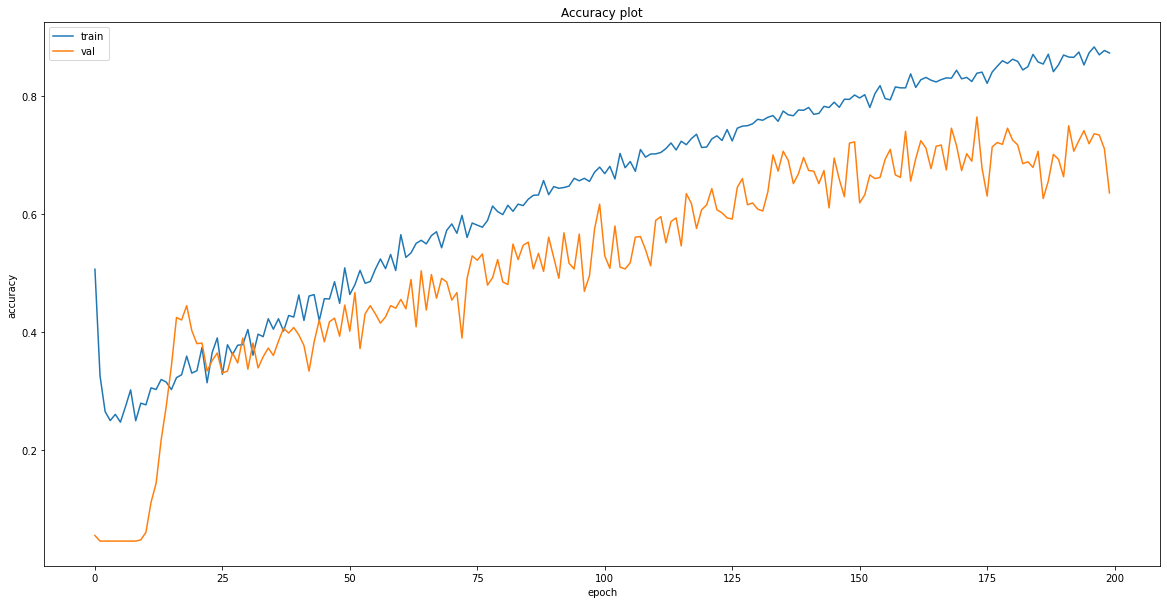

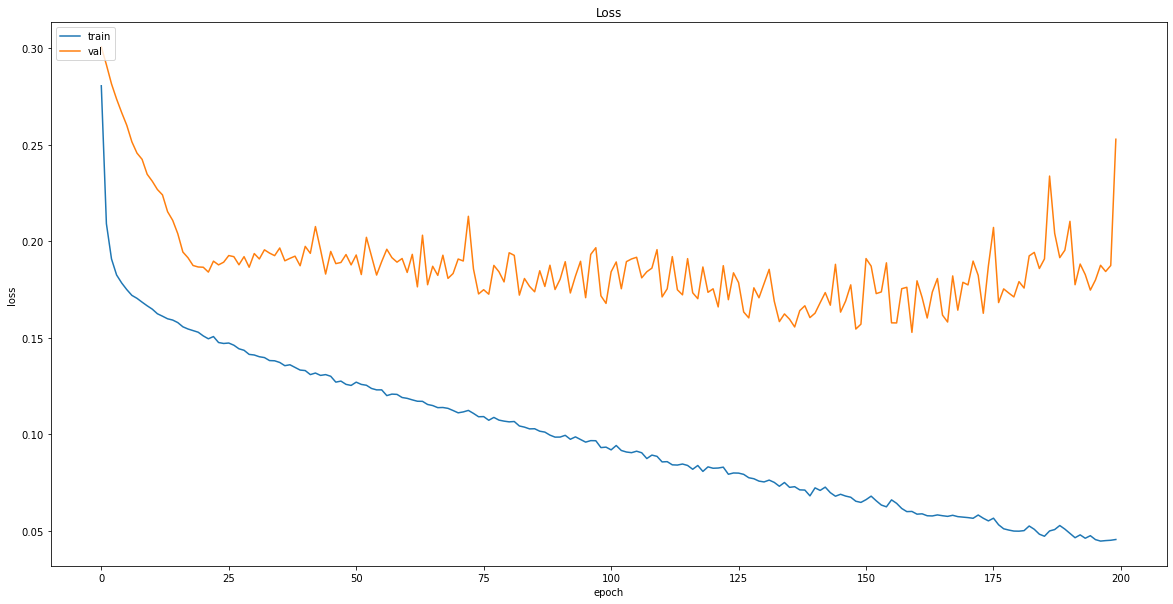

In [240]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [241]:
# Save model
model.save("models/{}".format('axl_time_series_lstm_buy_hold_sell_no_close.model'))

INFO:tensorflow:Assets written to: models/axl_time_series_lstm_buy_hold_sell_no_close.model\assets


### Test Performance

### non-recession

In [242]:
logger = []

In [243]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-01-22        14.61  13.028180  -0.258404  23356600.0     2.0
2019-01-23        14.52  13.257691  -3.886001  21174700.0     2.0
2019-01-24        14.18  13.399585 -13.535906  19629300.0     2.0
2019-01-25        14.38  13.550418  -8.579880  20903300.0     2.0
2019-01-28        14.71  13.728815  -4.790414  22287500.0     2.0


In [244]:
df.drop(['previous_1d'], axis='columns', inplace=True)

In [245]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(218, 15, 3)

In [246]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [247]:
model = tf.keras.models.load_model("models/axl_time_series_lstm_buy_hold_sell_no_close.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.3482 - accuracy: 0.5596 - mean_squared_error: 6.2621 - weighted_accuracy: 0.5596 - weighted_mean_squared_error: 6.2621
Test loss: 0.34819650650024414
Test accuracy: 0.5596330165863037


In [248]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({1: 66, 2: 129, 0: 23})

In [249]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [250]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test.csv")
df.set_index('Date', inplace=True)

In [251]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,14.01,14.312907,-83.060094,17347800.0,2.0,1,2
2019-02-12,14.34,14.266306,-68.852439,19189100.0,2.0,1,2
2019-02-13,14.45,14.277643,-50.819664,21493700.0,2.0,2,2
2019-02-14,14.70,14.304160,-44.808757,23008200.0,2.0,2,2
2019-02-15,16.83,14.365058,-31.147561,25735200.0,2.0,2,2


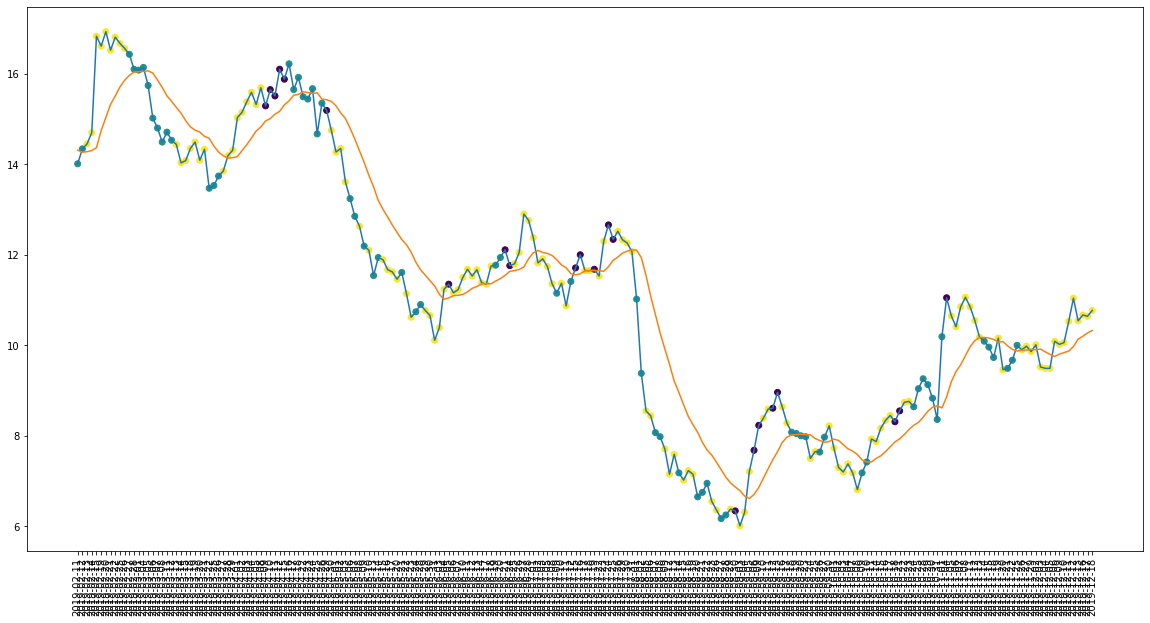

In [252]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

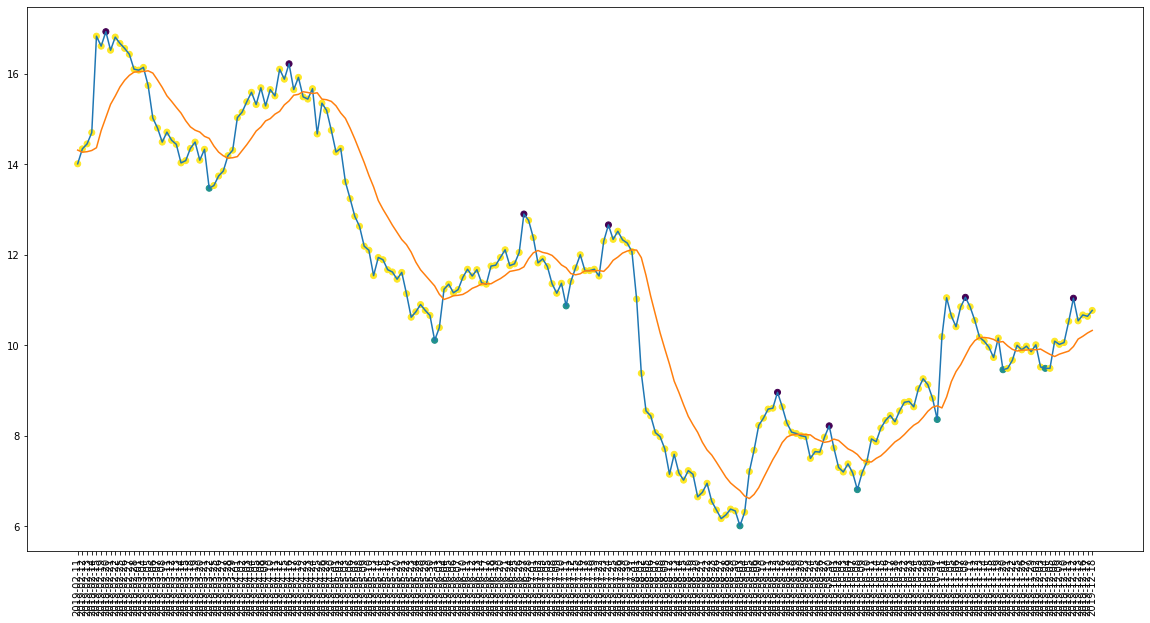

In [253]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [254]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 218
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 5
actual holds but predicted buy: 63
actual holds but predicted sell: 21
actual predicted holds: 118
Percentage buys correct: 25.0%
Percentage sells correct: 25.0%
Percentage holds correct: 58.415841584158414%
actual buys: 8
actual sells: 8
actual holds: 202


In [255]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[14.010000228881836, 14.34000015258789, 14.449999809265135, 14.699999809265135, 16.520000457763672, 16.610000610351562, 16.809999465942386, 16.829999923706055, 16.930000305175778]
[16.079999923706055, 16.100000381469727, 16.139999389648438, 16.430000305175778, 16.520000457763672, 16.559999465942386, 16.670000076293945, 16.809999465942386, 16.930000305175778]
Percentage buys correct: 42.42424242424242%
Percentage sells correct: 54.54545454545455%
Percentage holds correct: 83.72093023255815%


In [256]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $14.010000228881836
Shares owned at the moment: 711
Cash capital at the moment: $11.496784317492711


Stop Loss Activated!

Share price: $13.470000267028807
Shares owned at the moment: 0
Cash capital at the moment: $9562.329756152865


Share price: $13.470000267028807
Shares owned at the moment: 707
Cash capital at the moment: $12.850519344328859


Price increase from previously bought: 13.2002039583766%
Share price: $15.289999961853027
Shares owned at the moment: 0
Cash capital at the moment: $10793.152909948587


Share price: $16.219999313354492
Shares owned at the moment: 663
Cash capital at the moment: $9.720251446484326


Stop Loss Activated!

Share price: $15.649999618530273
Shares owned at the moment: 0
Cash capital at the moment: $10357.13613672757


Share price: $15.649999618530273
Shares owned at the moment: 659
Cash capital at the moment: $15.42467630743704


Stop Loss Activated!

Share price: $14.670000076293945
Shares owned at the moment: 0
Cash capital at the

In [257]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7647.909066392421
profit gained: -23.520909336075793%


In [258]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.733945,55.55555555555556%,22.22222222222222%,76.5%,59.375%,63.63636363636363%,81.70731707317073%,-11.565783517952005%,-7.777238176262399%
1,0.730233,25.0%,0.0%,78.28282828282828%,62.16216216216216%,55.55555555555556%,85.20710059171597%,-34.86491934328384%,-48.34563047105195%
2,0.692661,12.5%,33.333333333333336%,73.13432835820896%,58.333333333333336%,50.0%,86.16352201257861%,-8.207943820746005%,-5.545324129943856%
3,0.730233,25.0%,30.0%,78.23834196891191%,66.66666666666667%,51.851851851851855%,86.74698795180723%,-1.0883829350662744%,-7.669883276367181%
4,0.644550,12.5%,0.0%,69.58762886597938%,51.515151515151516%,51.851851851851855%,82.66666666666667%,-18.99364878754618%,-10.879329186439518%
5,0.751174,30.0%,30.0%,79.79274611398964%,47.82608695652174%,54.54545454545455%,82.63473053892216%,-19.087250471389332%,-41.56249103630067%
6,0.766055,36.36363636363637%,33.333333333333336%,80.09950248756219%,55.0%,48.0%,86.62790697674419%,7.952803013324737%,35.77290673755644%
7,0.762557,10.0%,8.333333333333334%,83.75634517766497%,58.8235294117647%,72.22222222222223%,81.4207650273224%,-34.76409514123919%,-14.13141708526613%
8,0.559633,25.0%,25.0%,58.415841584158414%,42.42424242424242%,54.54545454545455%,83.72093023255815%,-25.43736342608824%,-23.520909336075793%


### recession

In [259]:
logger = []

In [260]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test2.csv")
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2020-01-22         9.39  9.715390 -73.059349 -3592400.0     2.0
2020-01-23         9.34  9.657637 -75.342463 -4550300.0     2.0
2020-01-24         9.50  9.633386 -65.000010 -3092000.0     2.0
2020-01-27         9.31  9.583634 -66.883101 -4332600.0     2.0
2020-01-28         9.39  9.553844 -61.688301 -2300800.0     2.0


In [261]:
df.drop(['previous_1d'], axis='columns', inplace=True)

In [262]:
labels = []
data_15 = []
sequential = []
count = 0

for i in df.values:
    if count == 14:
        data_15.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_15_arr = min_max_scaler.fit_transform(data_15)
        sequential.append(data_15_arr)
        data_15 = data_15[1:15]
    else:
        data_15.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 15, 3)
y = labels
y = np.array(y)
X.shape

(219, 15, 3)

In [263]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [264]:
model = tf.keras.models.load_model("models/axl_time_series_lstm_buy_hold_sell_no_close.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1]);logger.append(score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.2233 - accuracy: 0.6575 - mean_squared_error: 6.0353 - weighted_accuracy: 0.6575 - weighted_mean_squared_error: 6.0353
Test loss: 0.22332043945789337
Test accuracy: 0.6575342416763306


In [265]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 148, 1: 47, 0: 24})

In [266]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [267]:
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test2.csv")
df.set_index('Date', inplace=True)

In [268]:
df = df.iloc[14:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,9.84,9.643918,-57.638900,-3274300.0,2.0,2,2
2020-02-12,10.34,9.674085,-36.805548,-1876100.0,0.0,2,0
2020-02-13,10.22,9.776533,-16.568036,-291400.0,2.0,2,2
2020-02-14,8.77,9.844759,-23.668622,-1567700.0,2.0,2,2
2020-02-18,8.27,9.679411,-90.686248,-6644000.0,2.0,1,2


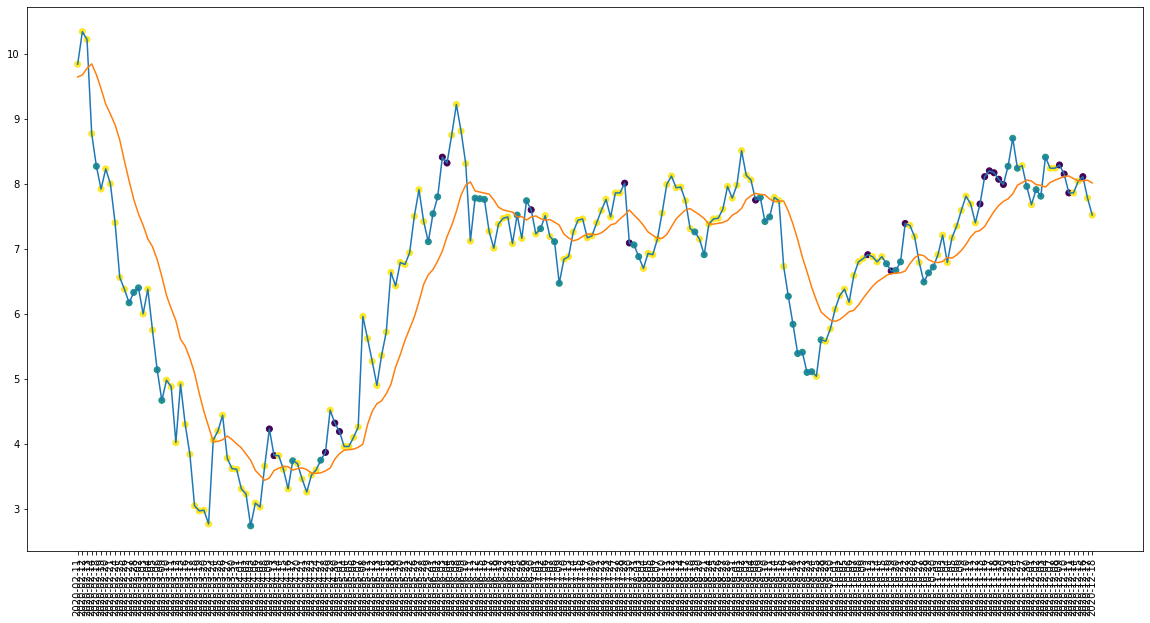

In [269]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

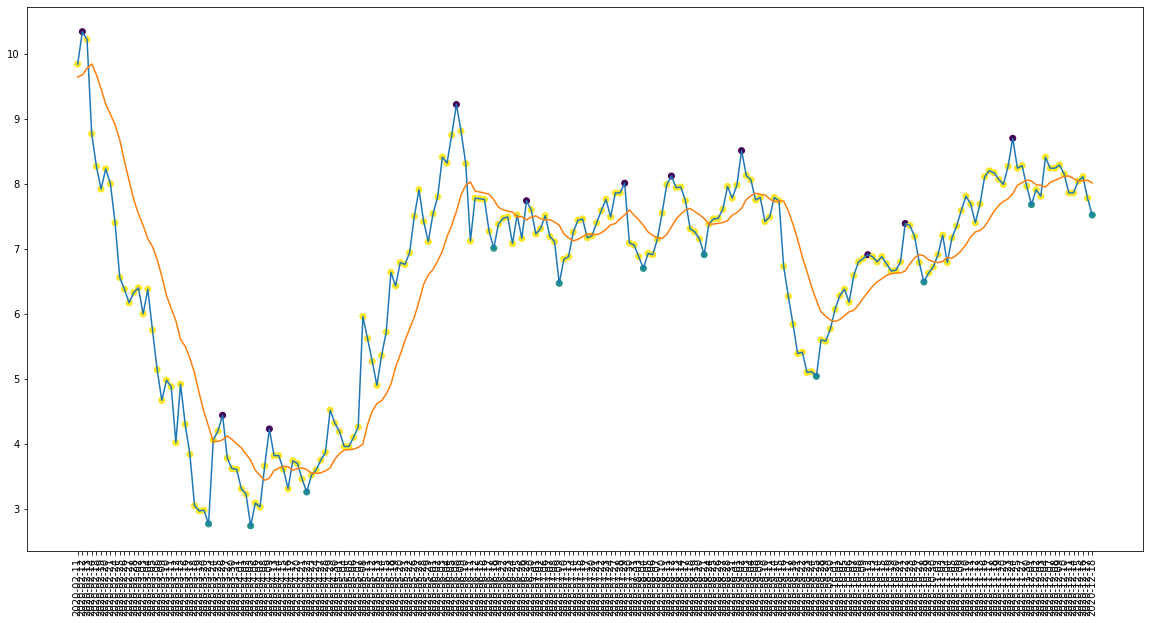

In [270]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [271]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold));logger.append(str(100*buy_buy/buy) + "%");logger.append(str(100*sell_sell/sell) + "%");logger.append(str(100*hold_hold/hold) + "%")

number of predictions: 219
actual predicted buys: 4
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 2
actual predicted sells: 4
actual sells but predicted hold: 5
actual holds but predicted buy: 41
actual holds but predicted sell: 20
actual predicted holds: 136
Percentage buys correct: 36.36363636363637%
Percentage sells correct: 36.36363636363637%
Percentage holds correct: 69.03553299492386%
actual buys: 11
actual sells: 11
actual holds: 197


In [272]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%");logger.append(str(100*correct_minima/buy) + "%"); logger.append(str(100*correct_maxima/sell) + "%"); logger.append(str(100*correct_hold/hold) + "%")

[7.400000095367432, 7.920000076293945, 8.0, 8.229999542236326, 8.270000457763674, 8.770000457763674, 9.84000015258789, 10.220000267028807, 10.34000015258789]
[6.0, 6.170000076293945, 6.329999923706055, 6.380000114440918, 6.4000000953674325, 6.559999942779541, 7.400000095367432, 8.0, 8.229999542236326]
Percentage buys correct: 53.191489361702125%
Percentage sells correct: 58.333333333333336%
Percentage holds correct: 86.39455782312925%


In [273]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $8.270000457763674
Shares owned at the moment: 1205
Cash capital at the moment: $7.244734377858549


Stop Loss Activated!

Share price: $7.920000076293945
Shares owned at the moment: 0
Cash capital at the moment: $9524.599926059243


Share price: $6.170000076293945
Shares owned at the moment: 1539
Cash capital at the moment: $2.856825819966616


Stop Loss Activated!

Share price: $6.0
Shares owned at the moment: 0
Cash capital at the moment: $9211.463325819966


Share price: $5.139999866485597
Shares owned at the moment: 1787
Cash capital at the moment: $1.0243200663280732


Stop Loss Activated!

Share price: $4.670000076293945
Shares owned at the moment: 0
Cash capital at the moment: $8323.36490852868


Share price: $4.670000076293945
Shares owned at the moment: 1777
Cash capital at the moment: $1.9536500815083855


Stop Loss Activated!

Share price: $4.019999980926514
Shares owned at the moment: 0
Cash capital at the moment: $7125.84888128113


Share price: $2.7400000095

In [274]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%');logger.append(str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7601.479205735086
profit gained: -23.98520794264914%


In [275]:
df_length = len(log)
log.loc[df_length] = logger
log.head(20)

,Test_accuracy,correct_buys,correct_sells,correct_holds,correct_low_buys,correct_high_sells,correct_mid_holds,Profit gained,buy_n_hold profit
0,0.733945,55.55555555555556%,22.22222222222222%,76.5%,59.375%,63.63636363636363%,81.70731707317073%,-11.565783517952005%,-7.777238176262399%
1,0.730233,25.0%,0.0%,78.28282828282828%,62.16216216216216%,55.55555555555556%,85.20710059171597%,-34.86491934328384%,-48.34563047105195%
2,0.692661,12.5%,33.333333333333336%,73.13432835820896%,58.333333333333336%,50.0%,86.16352201257861%,-8.207943820746005%,-5.545324129943856%
3,0.730233,25.0%,30.0%,78.23834196891191%,66.66666666666667%,51.851851851851855%,86.74698795180723%,-1.0883829350662744%,-7.669883276367181%
4,0.644550,12.5%,0.0%,69.58762886597938%,51.515151515151516%,51.851851851851855%,82.66666666666667%,-18.99364878754618%,-10.879329186439518%
5,0.751174,30.0%,30.0%,79.79274611398964%,47.82608695652174%,54.54545454545455%,82.63473053892216%,-19.087250471389332%,-41.56249103630067%
6,0.766055,36.36363636363637%,33.333333333333336%,80.09950248756219%,55.0%,48.0%,86.62790697674419%,7.952803013324737%,35.77290673755644%
7,0.762557,10.0%,8.333333333333334%,83.75634517766497%,58.8235294117647%,72.22222222222223%,81.4207650273224%,-34.76409514123919%,-14.13141708526613%
8,0.559633,25.0%,25.0%,58.415841584158414%,42.42424242424242%,54.54545454545455%,83.72093023255815%,-25.43736342608824%,-23.520909336075793%
9,0.657534,36.36363636363637%,36.36363636363637%,69.03553299492386%,53.191489361702125%,58.333333333333336%,86.39455782312925%,21.898579529688213%,-23.98520794264914%


In [276]:
experiment

'No close LSTM Time Series - cyclic'

In [277]:
log.to_csv('{}.csv'.format(experiment))